In [185]:
import os

import numpy as np 
print(np.version.version)
import pandas as pd 

import pickle

import itertools 

from eli5 import show_prediction, show_weights
from eli5.sklearn import PermutationImportance

from sklearn import datasets
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import xgboost as xgb 
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

import seaborn as sns 

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt 

from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier

import sys
sys.path.append('..')

from inxai import *
import shap
import lime


import logging

from ConfigSpace.hyperparameters import UniformFloatHyperparameter
from ConfigSpace.hyperparameters import Constant

# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from smac.facade.smac_bo_facade import SMAC4BO
# Import SMAC-utilities
from smac.scenario.scenario import Scenario


1.20.0


# 1. Helper functions

In [2]:
path = '../examples/'

def to_pickle(obj, name):
    with open(path + name + '.pickle', 'wb') as f:
        pickle.dump(obj, f)

def from_pickle(name):
    return pd.read_pickle(path + name + '.pickle')


In [109]:
## Nie uzywam stacking-ensemble poniewaz potrzebuje miec kontrole nad wagami gdy lacze modele
## Interesuje mnie srednia wazona z predykcji 3 modeli 

class weighted_model:
    '''
    Wrapper for classificators to combine up to 3 models.
    Weights are always scaled to sum up to 1 (or 100%). 
    '''
    def __init__(self, w1, m1, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None):
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3
        self.w4 = w4
        self.w5 = w5
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.m4 = m4
        self.m5 = m5
        self.colnames = None
        
    def predict(self, X):
        weighted_proba = self.predict_proba(X)
        return [0 if wp[0] > 0.5 else 1 for wp in weighted_proba]
    
    def predict_proba(self, X):
        w_ = self.w1 + self.w2 + self.w3 + self.w4 + self.w5
        m2_predict_proba = 0.0 if self.w2 == 0.0 else self.m2.predict_proba(X)
        m3_predict_proba = 0.0 if self.w3 == 0.0 else self.m3.predict_proba(X)
        m4_predict_proba = 0.0 if self.w4 == 0.0 else self.m4.predict_proba(X)
        m5_predict_proba = 0.0 if self.w5 == 0.0 else self.m5.predict_proba(X)
        weighted_prediction = (self.w1 * self.m1.predict_proba(X) + self.w2 * m2_predict_proba + self.w3 * m3_predict_proba + self.w4 * m4_predict_proba + self.w5 * m5_predict_proba) / w_
        return weighted_prediction

    def fit(self, X):
        self.colnames = X.columns
        return self


In [110]:
def AreaUnderTheCurveAccLoss(acc_loss):
    l = len(acc_loss)
    return auc(np.linspace(0, 1, l), acc_loss)

In [146]:
def weighted_shap(w1, m1, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None):
    return generate_per_instance_importances(models=weighted_model(w1=w1, m1=m1, w2=w2, m2=m2, w3=w3, m3=m3, w4=w4, m4=m4, w5=w5, m5=m5), X=X_test.iloc[:, ], y=y_test[:, ], framework='kernel_shap') 

def weighted_shap_naive(w1, shap1, w2 = 0.0, shap2 = None, w3 = 0.0, shap3 = None, w4 = 0.0, shap4 = None, w5 = 0.0, shap5 = None):
    '''
    Use this as a fast approximation 
    '''
    w_ = w1 + w2 + w3 + w4 + w5
    
    shapNone = [shap_i * 0.0 for shap_i in shap1]
    
    shap1_w = [shap_i * w1 for shap_i in shap1]
    shap2_w = shapNone if w2 == 0.0 else [shap_i * w2 for shap_i in shap2]
    shap3_w = shapNone if w3 == 0.0 else [shap_i * w3 for shap_i in shap3]
    shap4_w = shapNone if w4 == 0.0 else [shap_i * w4 for shap_i in shap4]
    shap5_w = shapNone if w5 == 0.0 else [shap_i * w5 for shap_i in shap5]
    
    shap_zip =  zip(shap1_w, shap2_w, shap3_w, shap4_w, shap5_w)
    
    return [(shap1_w_i + shap2_w_i + shap3_w_i + shap4_w_i + shap5_w_i) / w_ for shap1_w_i, shap2_w_i, shap3_w_i, shap4_w_i, shap5_w_i in shap_zip]


In [267]:
def weighted_acc_loss(X_test, y_test, ct, w1, m1, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None, plot=True):
#     print("debug-1")
    weighted_perm = PermutationImportance(weighted_model(w1=w1, m1=m1, w2=w2, m2=m2, w3=w3, m3=m3, w4=w4, m4=m4, w5=w5, m5=m5), random_state=2021, scoring="accuracy").fit(X_test, y_test)
#     print("debug-2")
    weighted_perm_importances = weighted_perm.feature_importances_
    show_weights(weighted_perm, feature_names=FEATURE_IDS)
    
    return gm.gradual_perturbation(model = weighted_model(w1=w1, m1=m1, w2=w2, m2=m2, w3=w3, m3=m3, w4=w4, m4=m4, w5=w5, m5=m5), X = X_test, y = y_test, column_transformer = ct, importances_orig = weighted_perm_importances, resolution=50,  count_per_step=10, plot=plot)

def weighted_acc_loss_auc(X_test, y_test, ct, w1, m1, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None, plot=True):
    w_acc_loss = weighted_acc_loss(X_test, y_test, ct, w1, m1, w2, m2, w3, m3, w4, m4, w5, m5, plot)
    return AreaUnderTheCurveAccLoss(w_acc_loss)

def weighted_acc_loss_auc_naive(w1, auc1, w2 = 0.0, auc2 = None, w3 = 0.0, auc3 = None, w4 = 0.0, auc4 = None, w5 = 0.0, auc5 = None):
    '''
    Use this as a fast approximation 
    '''
    return (w1 * auc1 + w2 * auc2 + w3 * auc3 + w4 * auc4 + w5 * auc5) / (w1 + w2 + w3 + w4 + w5)

In [239]:
def weighted_stability(X_test, w1, m1, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None):
    w_shap_ensemble = weighted_shap(w1=w1, m1=m1, w2=w2, m2=m2, w3=w3, m3=m3, w4=w4, m4=m4, w5=w5, m5=m5)
#     w_shap_ensemble_naive = weighted_shap_naive(w1=w1, shap1=shap1, w2=w2, shap2=shap2, w3=w3, shap3=shap3, w4=w4, shap4=shap4, w5=w5, shap5=shap5)
    return gm.stability(X_test, w_shap_ensemble, epsilon=0.3)

def weighted_stability_naive(w1, stability1, w2 = 0.0, stability2 = None, w3 = 0.0, stability3 = None, w4 = 0.0, stability4 = None, w5 = 0.0, stability5 = None):
    '''
    Use this as a fast approximation of weighted_stability
    '''
    stability1None = np.array(stability1) * 0.0
    
    stability1_w =  np.array(stability1) * w1
    stability2_w = stability1None if w2 == 0.0 else  np.array(stability2) * w2
    stability3_w = stability1None if w3 == 0.0 else  np.array(stability3) * w3
    stability4_w = stability1None if w4 == 0.0 else  np.array(stability4) * w4
    stability5_w = stability1None if w5 == 0.0 else  np.array(stability5) * w5

    return np.array(stability1 + stability2 + stability3 + stability4 + stability5) / (w1 + w2 + w3 + w4 + w5)


In [119]:
## czy to ma sens? ##
def weighted_consistency_naive(w1, shap1, w2 = 0.0, shap2 = None, w3 = 0.0, shap3 = None, w4 = 0.0, shap4 = None, w5 = 0.0, shap5 = None):
    '''
    Use this as a fast approximation 
    '''
    gm = GlobalFeatureMetric()
    
    w_ = w1 + w2 + w3 + w4 + w5
    
    shapNone = [shap_i * 0.0 for shap_i in shap1]
    
    shap1_w = [shap_i * w1 / w_ for shap_i in shap1]
    shap2_w = shapNone if w2 == 0.0 else [shap_i * w2 / w_ for shap_i in shap2]
    shap3_w = shapNone if w3 == 0.0 else [shap_i * w3 / w_ for shap_i in shap3]
    shap4_w = shapNone if w4 == 0.0 else [shap_i * w4 / w_ for shap_i in shap4]
    shap5_w = shapNone if w5 == 0.0 else [shap_i * w5 / w_ for shap_i in shap5]

    shapes = [shap1_w]
    if w2 > 0.0: shapes.append(shap2_w)
    if w3 > 0.0: shapes.append(shap3_w)
    if w4 > 0.0: shapes.append(shap4_w)
    if w5 > 0.0: shapes.append(shap5_w)

    return gm.consistency(shapes)


# 2. Syntetic



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       200 non-null    float64
 1   1       200 non-null    float64
 2   target  200 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 4.8 KB


<AxesSubplot:xlabel='0', ylabel='1'>

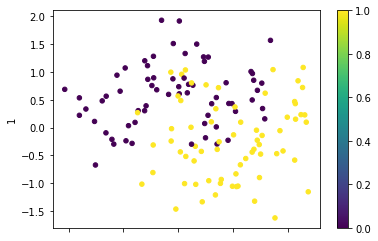

In [50]:
X, y = datasets.make_moons(n_samples=200,  noise=0.5, random_state=2021)
Xdf = pd.DataFrame(X, columns=['0','1'])
ydf = pd.DataFrame(y, columns=['target'])

df = pd.concat([Xdf, ydf], axis=1)
df.info()

# X=Xdf
# y=ydf

X_train, X_test, y_train, y_test = train_test_split(Xdf, y, test_size=0.33, random_state=42)
X_train.columns = ['0','1']
X_test.columns = ['0','1']
# y_train= pd.DataFrame(y_train, columns=['target'])
# y_test= pd.DataFrame(y_test, columns=['target'])

X_train.plot(kind='scatter',x='0', y='1',style='.', c=y_train, colormap='viridis')

In [51]:
TARGET_COL = "target"
FEATURE_IDS = [str(i) for i in range(X.shape[1])]


# 3.Classificators 
- svc_radial
- svc_lin
- xgbc
- lgbm
- rfc
- catboost

In [57]:
svc_radial = SVC(kernel='rbf',probability=True) # does not work with eli

svc_radial.fit(X_train, y_train)
svc_radial_preds = svc_radial.predict(X_test)

# to_pickle(svc_radial, 'model_svc_radial')

print(accuracy_score(y_test, svc_radial_preds))
print(classification_report(y_test, svc_radial_preds))

# show_prediction(svc_radial, X_train.iloc[1], feature_names = FEATURE_IDS, 
#                 show_feature_values=True)

0.7575757575757576
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        34
           1       0.79      0.69      0.73        32

    accuracy                           0.76        66
   macro avg       0.76      0.76      0.76        66
weighted avg       0.76      0.76      0.76        66



In [58]:
svc_lin = SVC(kernel='linear',probability=True) 
svc_lin.fit(X_train, y_train)
svc_lin_preds = svc_lin.predict(X_test)

# to_pickle(svc_lin, 'model_svc_lin')

print(accuracy_score(y_test, svc_lin_preds))
print(classification_report(y_test, svc_lin_preds))

show_prediction(svc_lin, X_train.iloc[1], feature_names = FEATURE_IDS, 
                show_feature_values=True)

0.8181818181818182
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        34
           1       0.86      0.75      0.80        32

    accuracy                           0.82        66
   macro avg       0.82      0.82      0.82        66
weighted avg       0.82      0.82      0.82        66



In [59]:
xgbc = xgb.XGBClassifier() 
xgbc.fit(X_train, y_train)
xgbc_preds = xgbc.predict(X_test)

# to_pickle(xgbc, 'model_xgbc')

print(accuracy_score(y_test, xgbc_preds))
print(classification_report(y_test, xgbc_preds))

show_prediction(xgbc, X_train.iloc[1], feature_names = FEATURE_IDS, 
                show_feature_values=True)

[06:46:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7424242424242424
              precision    recall  f1-score   support

           0       0.73      0.79      0.76        34
           1       0.76      0.69      0.72        32

    accuracy                           0.74        66
   macro avg       0.74      0.74      0.74        66
weighted avg       0.74      0.74      0.74        66



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [62]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 4, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4 }

lgbm = lgb.train(params,                                    # does not work with eli
                 lgb.Dataset(X_train,label=y_train),
#                  2500,
                 valid_sets=lgb.Dataset(X_test,label=y_test),
                 early_stopping_rounds= 15,
                 verbose_eval= 30
                 )

lgbm_preds = lgbm.predict(X_test)
lgbm_preds = (lgbm_preds > 0.5) * 1

# to_pickle(lgbm, 'model_lgbm')

print(accuracy_score(y_test, lgbm_preds))
print(classification_report(y_test, lgbm_preds))

# show_prediction(lgbm, X_train.iloc[1], feature_names = FEATURE_IDS, #estimator is not supported
#                 show_feature_values=True)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 134, number of used features: 2
[LightGBM] [Info] Start training from score 0.507463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 15 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [63]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc_preds = rfc.predict(X_test)

# to_pickle(rfc, 'model_rfc')

print(accuracy_score(y_test, rfc_preds))
print(classification_report(y_test, rfc_preds))

show_prediction(rfc, X_train.iloc[1], feature_names = FEATURE_IDS, 
                show_feature_values=True)

0.7424242424242424
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        34
           1       0.78      0.66      0.71        32

    accuracy                           0.74        66
   macro avg       0.75      0.74      0.74        66
weighted avg       0.75      0.74      0.74        66



In [64]:
ctbc = CatBoostClassifier(
#     custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent',
    iterations=1000, 
    learning_rate=0.1, 
    loss_function='CrossEntropy'
)

ctbc.fit(X_train, y_train)
ctbc_preds = ctbc.predict(X_test)

# to_pickle(ctbc, 'model_ctbc')

print(accuracy_score(y_test, ctbc_preds))
print(classification_report(y_test, ctbc_preds))

# show_prediction(ctbc, X_train.iloc[1], feature_names = FEATURE_IDS,  #estimator is not supported
#                 show_feature_values=True)

0.6515151515151515
              precision    recall  f1-score   support

           0       0.67      0.65      0.66        34
           1       0.64      0.66      0.65        32

    accuracy                           0.65        66
   macro avg       0.65      0.65      0.65        66
weighted avg       0.65      0.65      0.65        66



## read models from pickle's

# 4. Local explanations

## LIME values 
- fix by reset of index

In [70]:
X_test_copy = X_test.copy().reset_index(drop=True)

lime_svc_radial = generate_per_instance_importances(models=[svc_radial], X=X_test_copy, y=y_test, framework='lime') # does not work 
to_pickle(lime_svc_radial, 'lime_svc_radial')
# print(lime_svc_radial)

lime_svc_lin = generate_per_instance_importances(models=svc_lin, X=X_test_copy, y=y_test, framework='lime') # does not work 
to_pickle(lime_svc_lin, 'lime_svc_lin')
# print(lime_svc_lin)

lime_rfc = generate_per_instance_importances(models=rfc, X=X_test_copy, y=y_test, framework='lime') # does not work 
to_pickle(lime_rfc, 'lime_rfc')
# print(lime_rfc)

lime_ctbc = generate_per_instance_importances(models=ctbc, X=X_test_copy, y=y_test, framework='lime') # does not work 
to_pickle(lime_ctbc, 'lime_ctbc')
# print(lime_ctbc)

In [71]:
lime_xgbc = generate_per_instance_importances(models=xgbc, X=X_test_copy, y=y_test, framework='lime') # does not work 
to_pickle(lime_xgbc, 'lime_xgbc')
# print(lime_xgbc)

## not working
lime_lgbm = generate_per_instance_importances(models=lgbm, X=X_test_copy, y=y_test, framework='lime') # does not work 
to_pickle(lime_lgbm, 'lime_lgbm')
# print(lime_lgbm)


AttributeError: 'Booster' object has no attribute 'predict_proba'

### LIME's baseline

In [72]:
## 
lime_svc_radial = from_pickle('lime_svc_radial')
print(len(lime_svc_radial))

lime_svc_lin = from_pickle('lime_svc_lin')
print(len(lime_svc_lin))

## 
lime_xgbc = from_pickle('lime_xgbc')
print(len(lime_xgbc))

# lime_lgbm = from_pickle('lime_lgbm')
# print(len(lime_lgbm))

lime_rfc = from_pickle('lime_rfc')
print(len(lime_rfc))

lime_ctbc = from_pickle('lime_ctbc')
print(len(lime_ctbc))


66
66
66
66
66


## SHAP values

In [75]:
gm = GlobalFeatureMetric()

shap_svc_radial = generate_per_instance_importances(models=svc_radial, X=X_test.iloc[:, ], y=y_test[:, ], framework='kernel_shap') 
to_pickle(shap_svc_radial, 'shap_svc_radial')
print(len(shap_svc_radial))

shap_svc_lin = generate_per_instance_importances(models=svc_lin, X=X_test.iloc[:, ], y=y_test[:, ], framework='kernel_shap') 
to_pickle(shap_svc_lin, 'shap_svc_lin')
print(len(shap_svc_lin))


# # shap_xgbc = generate_per_instance_importances(models=xgbc, X=X_test.iloc[:, ], y=y_test.iloc[:, ], framework='kernel_shap') 
# # to_pickle(shap_xgbc, 'shap_xgbc')
# # print(len(shap_xgbc))

shap_xgbc_tree = generate_per_instance_importances(models=xgbc, X=X_test.iloc[:, ], y=y_test[:, ], framework='tree_shap') 
to_pickle(shap_xgbc_tree, 'shap_xgbc_tree')
print(len(shap_xgbc_tree))


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00859598 -0.44389542]
INFO:shap:phi = [0.00859598 0.44389542]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.04174907 0.07909871]
INFO:shap:phi = [-0.04174907 -0.07909871]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00212034 -0.36623353]
INFO:shap:phi = [0.00212034 0.36623353]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.20975902 -0.19355954]
INFO:shap:phi = [0.20975902 0.19355954]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.04742248 0.08211843]
INFO:shap:phi = [-0.04742248 -0.08211843]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.04021497 0.27966569]
INFO:shap:phi = [-0.04021497 -0.27966569]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.04444239 0.26418433]
INFO:shap:phi = [-0.04444239 -0.26418433]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.00626591 -0.41630347]
INFO:shap:phi = [-0.00626591  0.41630347]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00128875 -0.4098116 ]
INFO:shap:phi = [0.00

66


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.1068347 -0.3112759]
INFO:shap:phi = [0.1068347 0.3112759]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.06709329 -0.00051808]
INFO:shap:phi = [-0.06709329  0.00051808]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.00640776 -0.25226155]
INFO:shap:phi = [-0.00640776  0.25226155]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.23068956 -0.16095183]
INFO:shap:phi = [0.23068956 0.16095183]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.05438372 -0.00102237]
INFO:shap:phi = [-0.05438372  0.00102237]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.11550642 0.25533961]
INFO:shap:phi = [-0.11550642 -0.25533961]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.10844017 0.19892723]
INFO:shap:phi = [-0.10844017 -0.19892723]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.05741379 -0.28474606]
INFO:shap:phi = [0.05741379 0.28474606]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00756731 -0.28723922]
INFO:shap:phi = [0.00

66
66


In [79]:
# lgbm - nie udalo mi sie policzyc:  
shap_lgbm = generate_per_instance_importances(models=lgbm, X=X_test[0:10, ], y=y_test[0:10, ], framework='kernel_shap') # nie dziala
# shap_lgbm = generate_per_instance_importances(models=lgbm, X=X_test[0:10, ], y=y_test[0:10, ], framework='tree_shap') # nie dziala
to_pickle(shap_lgbm, 'shap_lgbm')
print(len(shap_lgbm))


TypeError: '(slice(0, 10, None),)' is an invalid key

In [80]:
shap_rfc = generate_per_instance_importances(models=rfc, X=X_test.iloc[:, ], y=y_test[:, ], framework='tree_shap')  
to_pickle(shap_rfc, 'shap_rfc')
print(len(shap_rfc))

shap_ctbc = generate_per_instance_importances(models=ctbc, X=X_test.iloc[:, ], y=y_test[:, ], framework='tree_shap')  
to_pickle(shap_ctbc, 'shap_ctbc')
print(len(shap_ctbc))

66
66


### SHAP's baseline

In [82]:
shap_svc_radial = from_pickle('shap_svc_radial')
print(len(shap_svc_radial))

shap_svc_lin = from_pickle('shap_svc_lin')
print(len(shap_svc_lin))

shap_xgbc = from_pickle('shap_xgbc_tree')
print(len(shap_xgbc))

shap_rfc = from_pickle('shap_rfc')
print(len(shap_rfc))

shap_ctbc = from_pickle('shap_ctbc')
print(len(shap_ctbc))


66
66
66
66
66


### modele Accuracy + Lime / Shap



### Consistency pairwaise {ctbc, rfc, svc_lin, svc_radial, xgbc}

In [88]:
shap_ctbc_rfc_consistency = gm.consistency([shap_ctbc, shap_rfc])
# shap_ctbc_svc_lin_consistency = gm.consistency([shap_ctbc, svc_lin]) # błąd
# shap_ctbc_svc_radial_consistency = gm.consistency([shap_ctbc, svc_radial]) # błąd
shap_ctbc_xgbc_consistency = gm.consistency([shap_ctbc, shap_xgbc])

shap_rfc_svc_lin_consistency = gm.consistency([shap_rfc, shap_svc_lin])
shap_rfc_svc_radial_consistency = gm.consistency([shap_rfc, shap_svc_radial])
shap_rfc_xgbc_consistency = gm.consistency([shap_rfc, shap_xgbc])

shap_svc_lin_svc_radial_consistency = gm.consistency([shap_svc_lin, shap_svc_radial])
shap_svc_lin_xgbc_consistency = gm.consistency([shap_svc_lin, shap_xgbc])

# shap_svc_radial_xgbc_consistency = gm.consistency([svc_radial, shap_xgbc]) # błąd


<AxesSubplot:xlabel='variable', ylabel='value'>

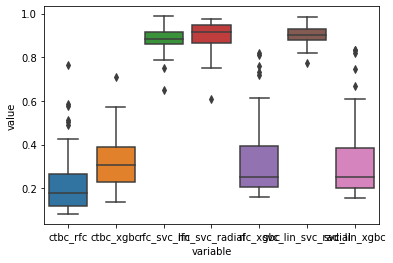

In [89]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'ctbc_rfc':shap_ctbc_rfc_consistency, 
                                                                'ctbc_xgbc':shap_ctbc_xgbc_consistency, 
                                                                'rfc_svc_lin':shap_rfc_svc_lin_consistency, 
                                                                'rfc_svc_radial':shap_rfc_svc_radial_consistency,
                                                               'rfc_xgbc':shap_rfc_xgbc_consistency,
                                                               'svc_lin_svc_radial':shap_svc_lin_svc_radial_consistency,
                                                               'svc_lin_xgbc':shap_svc_lin_xgbc_consistency})))

### Stability per model

In [91]:
shap_xgbc_stability = gm.stability(X_test, shap_xgbc, epsilon=0.3)
shap_rfc_stability = gm.stability(X_test, shap_rfc, epsilon=0.3)
shap_ctbc_stability = gm.stability(X_test, shap_ctbc, epsilon=0.3)

to_pickle(shap_xgbc_stability, 'shap_xgbc_stability')
to_pickle(shap_rfc_stability, 'shap_rfc_stability')
to_pickle(shap_ctbc_stability, 'shap_ctbc_stability')


In [93]:
shap_svc_lin_stability = gm.stability(X_test, shap_svc_lin, epsilon=0.3)
shap_svc_radial_stability = gm.stability(X_test, shap_svc_radial, epsilon=0.3)

to_pickle(shap_svc_lin_stability, 'shap_svc_lin_stability')
to_pickle(shap_svc_radial_stability, 'shap_svc_radial_stability')


<AxesSubplot:xlabel='variable', ylabel='value'>

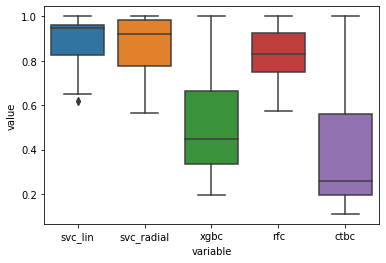

In [95]:
sns.boxplot(x="variable", y="value", data=pd.melt(pd.DataFrame({'svc_lin':shap_svc_lin_stability,'svc_radial':shap_svc_radial_stability,'xgbc':shap_xgbc_stability,'rfc':shap_rfc_stability,'ctbc':shap_ctbc_stability})))

### Area under the accuracy loss

In [96]:
ct = ColumnTransformer([('_INXAI_categorical_noise_perturber', CategoricalNoisePerturber(),FEATURE_IDS)])

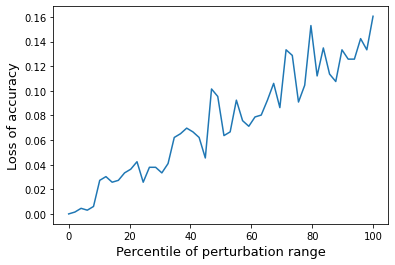

In [123]:
acc_loss_svc_lin = weighted_acc_loss(X_test, y_test, ct, w1=1.0, m1 = svc_lin, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None)
to_pickle(acc_loss_svc_lin, 'acc_loss_svc_lin')

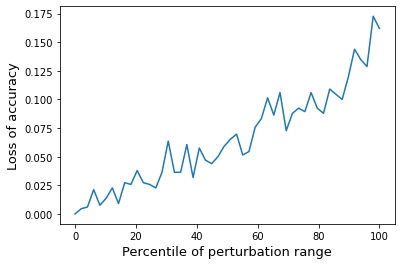

In [124]:
acc_loss_svc_radial = weighted_acc_loss(X_test, y_test, ct, w1=1.0, m1 = svc_radial, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None)
to_pickle(acc_loss_svc_radial, 'acc_loss_svc_radial')

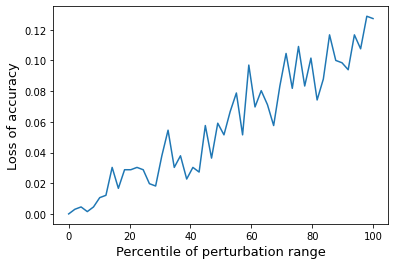

In [125]:
acc_loss_xgbc = weighted_acc_loss(X_test, y_test, ct, w1=1.0, m1 = xgbc, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None)
to_pickle(acc_loss_xgbc, 'acc_loss_xgbc')

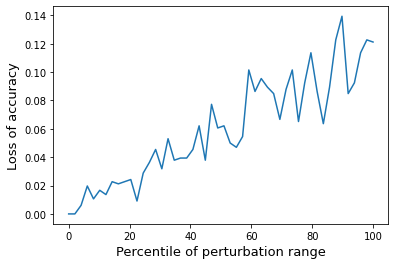

In [126]:
acc_loss_rfc = weighted_acc_loss(X_test, y_test, ct, w1=1.0, m1 = rfc, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None)
to_pickle(acc_loss_rfc, 'acc_loss_rfc')

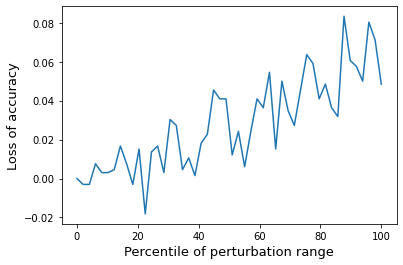

In [127]:
acc_loss_ctbc = weighted_acc_loss(X_test, y_test, ct, w1=1.0, m1 = ctbc, w2 = 0.0, m2 = None, w3 = 0.0, m3 = None, w4 = 0.0, m4 = None, w5 = 0.0, m5 = None)
to_pickle(acc_loss_ctbc, 'acc_loss_ctbc')

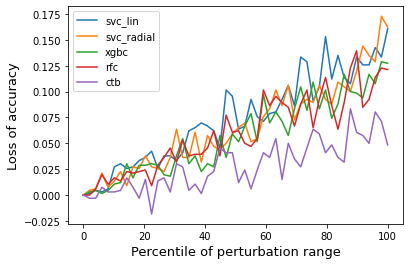

In [128]:
plt.plot(np.linspace(0, 100, 50), acc_loss_svc_lin)
plt.plot(np.linspace(0, 100, 50), acc_loss_svc_radial)
plt.plot(np.linspace(0, 100, 50), acc_loss_xgbc)
plt.plot(np.linspace(0, 100, 50), acc_loss_rfc)
plt.plot(np.linspace(0, 100, 50), acc_loss_ctbc)
plt.xlabel('Percentile of perturbation range', fontsize=13)
plt.ylabel('Loss of accuracy', fontsize=13)
plt.legend(['svc_lin','svc_radial','xgbc','rfc','ctb'])

In [131]:
svc_lin_auc_acc_loss = AreaUnderTheCurveAccLoss(acc_loss_svc_lin)
print(svc_lin_auc_acc_loss)

svc_radial_auc_acc_loss = AreaUnderTheCurveAccLoss(acc_loss_svc_radial)
print(svc_radial_auc_acc_loss)

xgbc_auc_acc_loss = AreaUnderTheCurveAccLoss(acc_loss_xgbc)
print(xgbc_auc_acc_loss)

rfc_auc_acc_loss = AreaUnderTheCurveAccLoss(acc_loss_rfc)
print(rfc_auc_acc_loss)

ctbc_auc_acc_loss = AreaUnderTheCurveAccLoss(acc_loss_ctbc)
print(ctbc_auc_acc_loss)



0.07377860235003086
0.06513605442176867
0.05729746444032157
0.059925788497217046
0.028262213976499667


# 5. Weighted model 

## Weights from SHAP
- intial weights = 1 / auc_acc_loss
- 
- those are starting points for experiments with SMAC optimization

In [249]:
# norm of SHAP values; those are absolute values: 
# w_svc_lin = 1 / np.mean([np.linalg.norm(x) for x in shap_svc_lin])
# w_svc_radial = 1 / np.mean([np.linalg.norm(x) for x in shap_svc_radial])
# w_xgbc = 1 / np.mean([np.linalg.norm(x) for x in shap_xgbc])
# w_rfc = 1 / np.mean([np.linalg.norm(x) for x in shap_rfc])
# w_ctbc = 1 / np.mean([np.linalg.norm(x) for x in shap_ctbc])

# does not scale to 100% - scaling is done in weighted_model
w_svc_lin = 1 / svc_lin_auc_acc_loss
w_svc_radial = 1 / svc_radial_auc_acc_loss
w_xgbc = 1 / xgbc_auc_acc_loss
w_rfc = 1 / rfc_auc_acc_loss
w_ctbc = 1 / ctbc_auc_acc_loss

# normalised to sum == 100% for a better SMAC performance
w_ = w_svc_lin + w_svc_radial + w_xgbc + w_rfc + w_ctbc

w_svc_lin = w_svc_lin / w_
w_svc_radial = w_svc_radial / w_
w_xgbc = w_xgbc / w_
w_rfc = w_rfc / w_
w_ctbc = w_ctbc / w_

print(w_svc_lin, w_svc_radial, w_xgbc, w_rfc, w_ctbc)
print(w_svc_lin + w_svc_radial + w_xgbc + w_rfc + w_ctbc)

0.13770319470951742 0.15597428083404155 0.177312370521807 0.16953551216558743 0.3594746417690466
1.0


### weighted model examples

In [162]:
print(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc, w4=w_svc_lin, m4=svc_lin, w5=w_svc_radial, m5=svc_radial).predict_proba(X_test)[0])
print(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc, w4=w_svc_lin, m4=svc_lin, w5=w_svc_radial, m5=svc_radial).predict(X_test)[0])

[0.02445286 0.97554714]
1


In [163]:
print(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=0.0, m3=None).predict_proba(X_test)[0])
print(weighted_model(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=0.0, m3=None).predict(X_test)[0])

[0.00257272 0.99742729]
1


### weighted AUC for Accuracy Loss
- accurate method

In [234]:
FEATURE_IDS

['0', '1']

In [235]:
X_test.columns

Index(['0', '1'], dtype='object')

debug-1
debug-2
0.05281385281385282


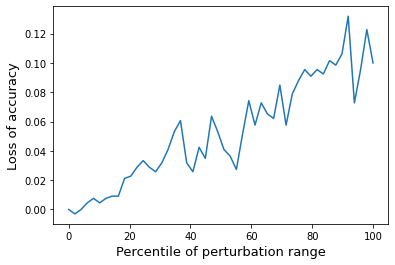

In [236]:
ct = ColumnTransformer([('_INXAI_categorical_noise_perturber', CategoricalNoisePerturber(),FEATURE_IDS)])

weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_acc_loss = weighted_acc_loss(X_test, y_test, ct, w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc, w4=w_svc_lin, m4=svc_lin, w5=w_svc_radial, m5=svc_radial)
to_pickle(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_acc_loss, "weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_acc_loss")
print(AreaUnderTheCurveAccLoss(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_acc_loss))

- approximate method
- convernce diff > 10% 

In [140]:
weighted_acc_loss_auc_naive(w1=w_xgbc, auc1=xgbc_auc_acc_loss, w2=w_rfc, auc2=rfc_auc_acc_loss, w3=w_ctbc, auc3=ctbc_auc_acc_loss, w4=w_svc_lin, auc4=svc_lin_auc_acc_loss, w5=w_svc_radial, auc5=svc_radial_auc_acc_loss)

0.05079774622401179

In [142]:
0.05615337043908473 / 0.05079774622401179 * 100

110.54303510131196

### weighted SHAP values

In [144]:
weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_shap_naive = weighted_shap_naive(w1=w_xgbc, shap1=shap_xgbc, w2=w_rfc, shap2=shap_rfc, w3=w_ctbc, shap3=shap_ctbc, w4=w_svc_lin, shap4=shap_svc_lin, w5=w_svc_radial, shap5=shap_svc_radial)
print(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_shap_naive)

[array([0.77175116, 3.79352181]), array([-0.35830525, -1.14660062]), array([-1.38705825, -1.09515088]), array([2.65862361, 0.57610699]), array([-0.27098561, -0.97841593]), array([1.12555168, 0.44876433]), array([-0.00405893, -0.72059695]), array([0.20714523, 3.08633304]), array([-0.01572323,  2.84165684]), array([2.63291748, 2.86440497]), array([-0.66118262, -1.45603635]), array([-0.25933499,  0.52407871]), array([-0.12532453,  0.2379926 ]), array([-0.14097076, -0.46805929]), array([-0.23430731, -3.89535017]), array([ 3.66310152, -0.09810384]), array([ 0.17148371, -2.79089281]), array([-0.70156198, -3.33270133]), array([-3.28013661, -1.67522223]), array([-1.18873263, -1.02929098]), array([-0.28510832, -1.86315093]), array([-0.45213234, -1.14773389]), array([-0.06298526, -1.54291234]), array([-0.434038  , -1.23405764]), array([-2.21897103, -1.69508106]), array([-4.90803041,  2.42560162]), array([0.1862821 , 0.51751235]), array([-0.03436442,  0.26475401]), array([ 0.18842268, -2.19339166

In [149]:
weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_shap = weighted_shap(w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc, w4=w_svc_lin, m4=svc_lin, w5=w_svc_radial, m5=svc_radial) 
to_pickle(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_shap, 'weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_shap')
print(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_shap)

[array([0.02551577, 0.46571357]), array([-0.07713437, -0.14858068]), array([-0.16924657, -0.04325174]), array([0.29553789, 0.17180859]), array([-0.08481117, -0.12997718]), array([-0.12559068, -0.00560578]), array([0.06520844, 0.16894979]), array([0.02590901, 0.44594782]), array([0.02690283, 0.43305169]), array([0.22434222, 0.28015515]), array([0.12749196, 0.25311112]), array([ 0.02438884, -0.23913846]), array([0.03204657, 0.03183521]), array([0.07890249, 0.14679136]), array([-0.04839751, -0.38491658]), array([0.44654773, 0.04789129]), array([0.0305833 , 0.38578116]), array([0.06977188, 0.38044536]), array([0.30768555, 0.151227  ]), array([0.22387027, 0.19391765]), array([-0.07207815, -0.2303777 ]), array([0.15604644, 0.22522508]), array([0.07431802, 0.21831919]), array([0.11500072, 0.20768329]), array([0.2530548 , 0.18683406]), array([-0.56839496,  0.28278454]), array([-0.00442043,  0.12620899]), array([ 0.04236306, -0.08046621]), array([0.0429828 , 0.35820679]), array([-0.12071543, -0

### weighted stability

In [155]:
weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_stability = weighted_stability(X_test[:], w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc, w4=w_svc_lin, m4=svc_lin, w5=w_svc_radial, m5=svc_radial)
to_pickle(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_stability, 'weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_stability')
print(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_stability)

[1.0, 0.7906190910637232, 0.6841417528491883, 0.9066666314681636, 0.8064608288985199, 0.7466202597751894, 0.8258635578668753, 0.549653137029724, 0.5940910659986836, 1.0, 0.8158646752891127, 0.6327776869139485, 0.8158646752891127, 0.8566763113637985, 0.6109503012615108, 0.9547599392341107, 0.7466202597751894, 1.0, 1.0, 0.9378357669086613, 0.7558259995664665, 0.9378357669086613, 0.7249375701665797, 0.9666730456814848, 0.977372566465294, 1.0, 0.7751346267633957, 0.8396974257470797, 0.7878082812663136, 0.7935956389112663, 0.8826588883338993, 0.9649062108897307, 0.7878082812663136, 0.66924449492122, 0.6569860362062422, 0.66924449492122, 0.8194626718757386, 0.7923944267982886, 0.8194626718757386, 0.865851031334694, 0.7122787330835617, 1.0, 0.9353695179119768, 1.0, 0.7473423824606126, 0.7049531063767461, 0.8541338278864665, 0.7109814765239348, 1.0, 1.0, 0.7249375701665797, 1.0, 0.8274275062710768, 0.8496614573867477, 0.6109503012615108, 1.0, 0.865851031334694, 0.549653137029724, 0.83086356306

In [260]:
print(weighted_stability_naive(w1=w_xgbc, stability1=shap_xgbc_stability, w2=w_rfc, stability2=shap_rfc_stability, w3=w_ctbc, stability3=shap_ctbc_stability, w4=w_svc_lin, stability4=shap_svc_lin_stability, w5=w_svc_radial, stability5=shap_svc_radial_stability))

[1.         0.47525558 0.19783733 0.46753797 0.45850322 0.35341235
 0.43584339 0.22617624 0.19783733 1.         0.41025732 0.22471664
 0.48340358 0.30764692 0.86229526 0.63560866 0.35341235 1.
 1.         0.40819271 0.44031916 0.40819271 0.56840649 0.89693677
 0.49571234 1.         0.44031916 0.47099708 0.29119495 0.44120415
 0.51342908 0.69801838 0.29119495 0.25800104 0.26916461 0.25800104
 0.35112555 0.45917791 0.35112555 0.33389985 0.22981706 1.
 0.67270081 1.         0.33389985 0.44130768 0.33269968 0.45372874
 1.         1.         0.56840649 1.         0.31342977 0.51777989
 0.30764692 1.         0.54770669 0.22471664 0.44120415 0.44130768
 0.56714671 0.51777989 0.7008584  0.41025732 0.22938461 1.
 1.         0.83834123 0.61036934 0.88766523 0.83043433 0.74914518
 0.85049499 0.590523   0.61036934 1.         0.9082078  0.72060424
 0.89724661 0.81633123 0.57207725 0.97106914 0.74914518 1.
 1.         0.94729179 0.7584504  0.89686419 0.73339372 0.89686419
 0.98370442 1.         0.86

### weighted consistency

In [159]:
weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_consistency_naive = weighted_consistency_naive(w1=w_xgbc, shap1=shap_xgbc, w2=w_rfc, shap2=shap_rfc, w3=w_ctbc, shap3=shap_ctbc, w4=w_svc_lin, shap4=shap_svc_lin, w5=w_svc_radial, shap5=shap_svc_radial) 
to_pickle(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_consistency_naive, 'weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_consistency_naive')
print(weighted_svc_lin_svc_radial_xgbc_rfc_ctbc_consistency_naive)


[0.26247390120855363, 0.46960682159268513, 0.3891659681767395, 0.354090350333444, 0.5123584209582885, 0.4922006538899875, 0.6455600949131134, 0.31910822495803287, 0.3384429522341566, 0.2558957756956487, 0.4453573152655696, 0.5969208784489841, 0.5988062143280284, 0.6709251213162153, 0.24915383024002705, 0.2668939275276059, 0.2846336865941613, 0.2476490966660093, 0.24809119487803946, 0.4494959043353055, 0.389239027777095, 0.48381564535382277, 0.4124410573243983, 0.47623484642091946, 0.311623206325747, 0.19402942039692142, 0.6301145025464753, 0.7394276028580323, 0.350059374317697, 0.4576812858395198, 0.5451497654221951, 0.36171573489780545, 0.8725735411689566, 0.5129166747361781, 0.5551436879656031, 0.30346595028034906, 0.2787102487814045, 0.3875346847856095, 0.2675227219749054, 0.4199291193581278, 0.33065129179650926, 0.254641903225555, 0.5156486185700079, 0.26462055497448417, 0.6572795223753461, 0.5384506999110702, 0.4364446590712566, 0.38978894530615804, 0.24385664551511088, 0.24651341

# 6. SMAC 

From examples
- https://automl.github.io/SMAC3/master/examples/SMAC4BO_rosenbrock.html#sphx-glr-examples-smac4bo-rosenbrock-py 
- https://automl.github.io/SMAC3/master/examples/SMAC4HPO_rosenbrock.html#sphx-glr-examples-smac4hpo-rosenbrock-py

## Optimizing weighted model = xgbc + rfc (we exclude ctbc).
## Firstly we use SHAP values. 

In [354]:
def exact_joint_metrics(w_xgbc, w_rfc, w_ctbc, w_svc_lin, w_svc_radial, importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 1.0):
#     print("debug-0")
    w_ = w_svc_lin + w_svc_radial + w_xgbc + w_rfc + w_ctbc
    
#     print("debug-1a")    
    ct = ColumnTransformer([('_INXAI_categorical_noise_perturber', CategoricalNoisePerturber(),FEATURE_IDS)])
#     print("debug-1b")
    w_acc_loss = weighted_acc_loss(X_test[:], y_test[:], ct, w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc, w4=w_svc_lin, m4=svc_lin, w5=w_svc_radial, m5=svc_radial, plot = False)
#     print("debug-1c")
    w_auc_acc_loss = AreaUnderTheCurveAccLoss(w_acc_loss)    
#     print("debug-1d")

    w_stability = weighted_stability(X_test[:], w1=w_xgbc, m1=xgbc, w2=w_rfc, m2=rfc, w3=w_ctbc, m3=ctbc, w4=w_svc_lin, m4=svc_lin, w5=w_svc_radial, m5=svc_radial)
    w_stability_m = np.mean(w_stability)
    print("debug-2")
    
    w_consistency = weighted_consistency_naive(w_xgbc, shap_xgbc[:], w_rfc, shap_rfc[:], w_ctbc, shap_ctbc[:], w_svc_lin, shap_svc_lin[:], w_svc_radial, shap_svc_radial[:])
    w_consistency_m = np.mean(w_consistency)
    print("debug-3")
    
    joint_metric = get_joint_metric(w_auc_acc_loss, importance_auc_acc_loss, w_stability_m, importance_stability, w_consistency_m, importance_consistency)
    
    print(f'AUC_acc_loss={w_auc_acc_loss}, stability={w_stability_m}, consistency={w_consistency_m}, joint_metric={joint_metric}')
    
    return {'auc_acc_loss' : w_auc_acc_loss, 'stability' : w_stability_m, 'consistency' : w_consistency_m, 'joint_metric' : joint_metric, 
            'w_svc_lin' : w_svc_lin, 'w_svc_radial' : w_svc_radial, 'w_xgbc' : w_xgbc, 'w_rfc' : w_rfc, 'w_ctbc' : w_ctbc, 'w_' : w_}


def naive_joint_metrics(w_xgbc, w_rfc, w_ctbc, w_svc_lin, w_svc_radial, importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 1.0):
#     print("debug-0")
    w_ = w_svc_lin + w_svc_radial + w_xgbc + w_rfc + w_ctbc
    
#     print("debug-1a")    
#     print("debug-1b")
#     print("debug-1c")
    w_auc_acc_loss = weighted_acc_loss_auc_naive(w1=w_xgbc, auc1=xgbc_auc_acc_loss, w2=w_rfc, auc2=rfc_auc_acc_loss, w3=w_ctbc, auc3=ctbc_auc_acc_loss, w4=w_svc_lin, auc4=svc_lin_auc_acc_loss, w5=w_svc_radial, auc5=svc_radial_auc_acc_loss)
#     print("debug-1d")

    w_stability = weighted_stability_naive(w1=w_xgbc, stability1=shap_xgbc_stability, w2=w_rfc, stability2=shap_rfc_stability, w3=w_ctbc, stability3=shap_ctbc_stability, w4=w_svc_lin, stability4=shap_svc_lin_stability, w5=w_svc_radial, stability5=shap_svc_radial_stability)
    w_stability_m = np.mean(w_stability)
#     print("debug-2")
    
    w_consistency = weighted_consistency_naive(w_xgbc, shap_xgbc[:], w_rfc, shap_rfc[:], w_ctbc, shap_ctbc[:], w_svc_lin, shap_svc_lin[:], w_svc_radial, shap_svc_radial[:])
    w_consistency_m = np.mean(w_consistency)
#     print("debug-3")
    
    joint_metric = get_joint_metric(w_auc_acc_loss, importance_auc_acc_loss, w_stability_m, importance_stability, w_consistency_m, importance_consistency)
    
    print(f'AUC_acc_loss={w_auc_acc_loss}, stability={w_stability_m}, consistency={w_consistency_m}, joint_metric={joint_metric}')
    
    return {'auc_acc_loss' : w_auc_acc_loss, 'stability' : w_stability_m, 'consistency' : w_consistency_m, 'joint_metric' : joint_metric, 
            'w_svc_lin' : w_svc_lin, 'w_svc_radial' : w_svc_radial, 'w_xgbc' : w_xgbc, 'w_rfc' : w_rfc, 'w_ctbc' : w_ctbc, 'w_' : w_}

def optimize_joint_metrics(x, method = 'naive'):

    print(method)
    
    w_xgbc = x["w0"]
    w_rfc = x["w1"] if "w1" in x else 0.0
    w_ctbc = x["w2"] if "w2" in x else 0.0
    w_svc_lin = x["w3"] if "w3" in x else 0.0
    w_svc_radial = x["w4"] if "w4" in x else 0.0
    
    # works only if w_xgbc + w_rfc + w_ctbc + w_svc_lin <= 1
#     if w_rfc == -1.0: 
#         w_rfc = 1.0 - w_xgbc
#     elif w_ctbc == -1.0:
#         w_ctbc = 1.0 - (w_xgbc + w_rfc)
#     elif w_svc_lin == -1.0:
#         w_svc_lin = 1.0 - (w_xgbc + w_rfc + w_ctbc)
#     elif w_svc_radial == -1.0:
#         print("debug-1")
#         w_svc_radial = 1.0 - (w_xgbc + w_rfc + w_ctbc + w_svc_lin)

    w_ = w_svc_lin + w_svc_radial + w_xgbc + w_rfc + w_ctbc
    
    w_xgbc = w_xgbc / w_
    w_rfc = w_rfc / w_
    w_ctbc = w_ctbc / w_
    w_svc_lin = w_svc_lin / w_
    w_svc_radial = w_svc_radial / w_
    w_ = w_svc_lin + w_svc_radial + w_xgbc + w_rfc + w_ctbc
    
    print(f'w_svc_lin={w_svc_lin}, w_svc_radial={w_svc_radial}, w_xgbc={w_xgbc}, w_rfc={w_rfc}, w_ctbc={w_ctbc}, w_={w_}')

    
    importance_auc_acc_loss = x["importance_auc_acc_loss"]
    importance_stability = x["importance_stability"]
    importance_consistency = x["importance_consistency"]
    print(f'importance_auc_acc_loss={importance_auc_acc_loss}, importance_stability={importance_stability}, importance_consistency={importance_consistency}')
    
    joint_metric = {}
    if method == 'naive': 
        joint_metric = naive_joint_metrics(w_xgbc, w_rfc, w_ctbc, w_svc_lin, w_svc_radial, importance_auc_acc_loss, importance_stability, importance_consistency)
    elif method == 'exact': 
        joint_metric = exact_joint_metrics(w_xgbc, w_rfc, w_ctbc, w_svc_lin, w_svc_radial, importance_auc_acc_loss, importance_stability, importance_consistency)
#     print("debug-4")
    
    return joint_metric['joint_metric']


def get_joint_metric(w_auc_acc_loss, importance_auc_acc_loss, w_stability_m, importance_stability, w_consistency_m, importance_consistency):
    return pow(w_auc_acc_loss, importance_auc_acc_loss) / (pow(w_stability_m, importance_stability) * pow(w_consistency_m, importance_consistency))


In [346]:
def run_experiment(importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 1.0):
    logging.basicConfig(level=logging.INFO)  # logging.DEBUG for debug output

    # Build Configuration Space which defines all parameters and their ranges
    cs = ConfigurationSpace()

    x0 = UniformFloatHyperparameter("w0", 0.0, 1.0, default_value=w_xgbc)
    x1 = UniformFloatHyperparameter("w1", 0.0, 1.0, default_value=w_rfc)
    x2 = UniformFloatHyperparameter("w2", 0.0, 1.0, default_value=w_ctbc)
    x3 = UniformFloatHyperparameter("w3", 0.0, 1.0, default_value=w_svc_lin)
        
#     print(dir(x0))
#     w_complement_to_1 = -1 ## handle later on
#     x4 = Constant("w4", w_complement_to_1)
    x4 = UniformFloatHyperparameter("w4", 0.0, 1.0, default_value=w_svc_radial)
    
    i_auc_acc_loss = Constant("importance_auc_acc_loss", importance_auc_acc_loss)
    i_stability = Constant("importance_stability", importance_stability)
    i_consistency = Constant("importance_consistency", importance_consistency)

    cs.add_hyperparameters([x0, x1, x2, x3, x4, i_auc_acc_loss, i_stability, i_consistency])

    # Scenario object
    scenario = Scenario({"run_obj": "quality",  # we optimize quality (alternatively runtime)
                         "runcount-limit": 30,  # max. number of function evaluations; for this example set to a low number
                         "cs": cs,  # configuration space
                         "deterministic": "true",
                         "abort_on_first_run_crash": "true"
                         })

    # Example call of the function
    # It returns: Status, Cost, Runtime, Additional Infos
    def_value = optimize_joint_metrics(cs.get_default_configuration())
    print("Default Value: %.2f" % def_value)

    # Optimize, using a SMAC-object
    print("Optimizing! Depending on your machine, this might take a few minutes.")
    smac = SMAC4BO(scenario=scenario,
                   rng=np.random.RandomState(2021),
                   tae_runner=optimize_joint_metrics,
                   )

    cfg = smac.optimize()
    
    return {k: cfg[k] for k in cfg if cfg[k]}


In [343]:
## Przyklad - SMAC zaczyna od tej wartosci:
## ! problem: dziala "na sycho", w SMAC ta sama f. z tymi samymi parametrami wywla się 

w_xgbc_test = 0.2
w_rfc_test = 0.2
w_ctbc_test = 0.2
w_svc_lin_test = 0.2
w_svc_radial_test = 0.2

weighted_acc_loss(X_test, y_test, ct, w1=w_xgbc_test, m1=xgbc, w2=w_rfc_test, m2=rfc, w3=w_ctbc_test, m3=ctbc, w4=w_svc_lin_test, m4=svc_lin, w5=w_svc_radial_test, m5=svc_radial, plot = False)

[0.0,
 0.00757575757575768,
 -0.003030303030302939,
 -0.00454545454545463,
 0.00454545454545463,
 0.00454545454545463,
 0.021212121212121238,
 0.010606060606060619,
 0.027272727272727226,
 0.036363636363636376,
 0.018181818181818188,
 0.013636363636363669,
 0.028787878787878807,
 0.021212121212121127,
 0.045454545454545414,
 0.03181818181818186,
 0.046969696969696884,
 0.028787878787878807,
 0.045454545454545414,
 0.030303030303030276,
 0.022727272727272596,
 0.05454545454545445,
 0.04999999999999993,
 0.051515151515151514,
 0.051515151515151514,
 0.048484848484848464,
 0.046969696969696884,
 0.04999999999999993,
 0.05606060606060603,
 0.05303030303030287,
 0.09696969696969704,
 0.06666666666666665,
 0.08787878787878789,
 0.09242424242424241,
 0.056060606060606144,
 0.08030303030303021,
 0.07424242424242422,
 0.07878787878787874,
 0.054545454545454675,
 0.0984848484848484,
 0.08636363636363631,
 0.10909090909090913,
 0.1166666666666667,
 0.07878787878787885,
 0.08636363636363642,
 0.10

### Wszystkie eksperymenty zbiegaja sie do podobnych metryk, gdy liczymy exact_joint_metrics ?

In [355]:
# importance_auc_acc_loss = importance_stability = importance_consistency = 1.0
e1 = run_experiment()
to_pickle(e1, 'e1')
print(naive_joint_metrics(e1['w0'], e1['w1'], e1['w2'], e1['w3'], e1['w4'], e1['importance_auc_acc_loss'], e1['importance_consistency'], e1['importance_stability']))
r1 = exact_joint_metrics(e1['w0'], e1['w1'], e1['w2'], e1['w3'], e1['w4'], e1['importance_auc_acc_loss'], e1['importance_consistency'], e1['importance_stability'])
to_pickle(r1, 'r1')
r1

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-02-09_15:02:05_453514
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:sma

naive
w_svc_lin=0.1377031947, w_svc_radial=0.1559742808, w_xgbc=0.1773123705, w_rfc=0.1695355122, w_ctbc=0.3594746418, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05079774622277981, stability=0.7067812153419838, consistency=0.4096159680933908, joint_metric=0.17546179471211973
Default Value: 0.18
Optimizing! Depending on your machine, this might take a few minutes.
naive
w_svc_lin=0.2, w_svc_radial=0.2, w_xgbc=0.2, w_rfc=0.2, w_ctbc=0.2, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.056880024737167564, stability=0.7067812153419838, consistency=0.5328851601905255, joint_metric=0.15102232501532784


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1510


naive
w_svc_lin=0.09090909090909091, w_svc_radial=0.2727272727272727, w_xgbc=0.2727272727272727, w_rfc=0.09090909090909091, w_ctbc=0.2727272727272727, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.053253780851183416, stability=0.7067812153419838, consistency=0.46014605337703784, joint_metric=0.16374564069646827


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.069721 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3333333333333333, w_svc_radial=0.1111111111111111, w_xgbc=0.1111111111111111, w_rfc=0.3333333333333333, w_ctbc=0.1111111111111111, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06131210059781485, stability=0.7067812153419838, consistency=0.6527278808485087, joint_metric=0.1329012401482329


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1329) is better than incumbent (0.1510) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035836 sec, available: 0.000010 sec)


naive
w_svc_lin=0.05263157894736842, w_svc_radial=0.3684210526315789, w_xgbc=0.15789473684210525, w_rfc=0.15789473684210525, w_ctbc=0.2631578947368421, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05382693747355398, stability=0.7067812153419838, consistency=0.47059273922098976, joint_metric=0.16183388143920924


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035284 sec, available: 0.000010 sec)


naive
w_svc_lin=0.21739130434782608, w_svc_radial=0.13043478260869565, w_xgbc=0.30434782608695654, w_rfc=0.30434782608695654, w_ctbc=0.043478260869565216, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.0614402678067274, stability=0.7067812153419838, consistency=0.5733404953649649, joint_metric=0.15161964808717596


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036698 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23076923076923078, w_svc_radial=0.07692307692307693, w_xgbc=0.38461538461538464, w_rfc=0.07692307692307693, w_ctbc=0.23076923076923078, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05520550877693732, stability=0.7067812153419838, consistency=0.47958632129918666, joint_metric=0.16286607514687013


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034512 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28, w_svc_radial=0.2, w_xgbc=0.04, w_rfc=0.2, w_ctbc=0.28, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05587569573283855, stability=0.7067812153419838, consistency=0.46691930109578994, joint_metric=0.16931526651806103


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033879 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33343027476046705, w_svc_radial=0.1100184324624556, w_xgbc=0.11151399871705266, w_rfc=0.3335192790935111, w_ctbc=0.11151801496651352, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.061293807413294765, stability=0.7067812153419839, consistency=0.6519502197825401, joint_metric=0.13302006783066228


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036132 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3432691228727619, w_svc_radial=0.11395497146786025, w_xgbc=0.1146358019031445, w_rfc=0.343384384847589, w_ctbc=0.08475571890864458, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06228979840491995, stability=0.7067812153419837, consistency=0.6985964563119135, joint_metric=0.1261553139151956


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1262) is better than incumbent (0.1329) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25 -> 0.25054646993342505
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.75 -> 0.7504963024249074
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.25 -> 0.1852409616078941
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.75 -> 0.7502443873998362
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25 -> 0.2490584560725561
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035751 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3655455809671682, w_svc_radial=0.12143404484745465, w_xgbc=0.12213567860793992, w_rfc=0.3656373245386136, w_ctbc=0.025247371038823654, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06450189289439258, stability=0.7067812153419838, consistency=0.7414462945871794, joint_metric=0.12308574601947014


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1231) is better than incumbent (0.1262) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25054646993342505 -> 0.2506923739863765
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7504963024249074 -> 0.7504972334976109
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.1852409616078941 -> 0.051822067513580164
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7502443873998362 -> 0.7503089231366601
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.2490584560725561 -> 0.24925221960159868
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036835 sec, available: 0.000010 sec)


naive
w_svc_lin=0.36285560064848155, w_svc_radial=0.11633085359916809, w_xgbc=0.11132298456583725, w_rfc=0.3629740510607184, w_ctbc=0.046516510125794816, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06379300240770155, stability=0.7067812153419837, consistency=0.7511059728468296, joint_metric=0.12016744538236593


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1202) is better than incumbent (0.1231) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2506923739863765 -> 0.23019207854909007
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7504972334976109 -> 0.7505525619791122
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.051822067513580164 -> 0.09618617569827972
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7503089231366601 -> 0.7503076319073564
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.24925221960159868 -> 0.2405472786578537
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036029 sec, available: 0.000010 sec)


naive
w_svc_lin=0.4004092595642341, w_svc_radial=0.1089934721513994, w_xgbc=0.03919190284263627, w_rfc=0.40052770659492914, w_ctbc=0.05087765884680112, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06432649084544027, stability=0.7067812153419838, consistency=0.781124339580161, joint_metric=0.11651576512468577


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1165) is better than incumbent (0.1202) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.23019207854909007 -> 0.07343981965802733
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7505525619791122 -> 0.7505295840949856
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.09618617569827972 -> 0.09533719516845941
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.2405472786578537 -> 0.20423761946034083
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036520 sec, available: 0.000010 sec)


naive
w_svc_lin=0.42162923961519166, w_svc_radial=0.04412977652920523, w_xgbc=0.06437938623614624, w_rfc=0.4215723398018624, w_ctbc=0.048289257817594466, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06429824733634776, stability=0.7067812153419838, consistency=0.7779142281487453, joint_metric=0.11694520557603134


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036758 sec, available: 0.000010 sec)


naive
w_svc_lin=0.44098761201729225, w_svc_radial=0.09134694810018719, w_xgbc=0.06345958849999767, w_rfc=0.34562240405638167, w_ctbc=0.05858344732614119, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06448889597570064, stability=0.7067812153419838, consistency=0.7580554581810091, joint_metric=0.12036465199563366


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036666 sec, available: 0.000010 sec)


naive
w_svc_lin=0.38247838027308717, w_svc_radial=0.05743724460351199, w_xgbc=0.0004733540872334574, w_rfc=0.5095201419520571, w_ctbc=0.05009087908411029, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06393615320960082, stability=0.7067812153419839, consistency=0.7721662956951925, joint_metric=0.11715225791546144


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036164 sec, available: 0.000010 sec)


naive
w_svc_lin=0.47276637810018485, w_svc_radial=0.05861351319986052, w_xgbc=0.005006799343976245, w_rfc=0.41653461610761117, w_ctbc=0.04707869324836715, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06527648591627991, stability=0.7067812153419839, consistency=0.7847571956260513, joint_metric=0.1176891596135233


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036314 sec, available: 0.000010 sec)


naive
w_svc_lin=0.407495810407324, w_svc_radial=0.07382067774533116, w_xgbc=0.03847768178311797, w_rfc=0.433619551511747, w_ctbc=0.04658627855247977, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06437915754710154, stability=0.7067812153419838, consistency=0.7881184698239477, joint_metric=0.11557629955883976


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1156) is better than incumbent (0.1165) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.07343981965802733 -> 0.07780399839122923
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7505295840949856 -> 0.876802689891461
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.09533719516845941 -> 0.09420002904490937
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7503076319073564 -> 0.8239790420865356
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.20423761946034083 -> 0.14926948886658678
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037634 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3280002910192509, w_svc_radial=0.31812784759114715, w_xgbc=1.042447912532519e-05, w_rfc=0.3297669764693602, w_ctbc=0.024094460441116534, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06536410201370757, stability=0.7067812153419838, consistency=0.8575589122694438, joint_metric=0.1078425965608746


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1078) is better than incumbent (0.1156) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.07780399839122923 -> 3.1610340870918464e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.876802689891461 -> 0.999958502372026
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.09420002904490937 -> 0.07306207806529567
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8239790420865356 -> 0.9946013494036847
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.14926948886658678 -> 0.9646649565883283
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036361 sec, available: 0.000010 sec)


naive
w_svc_lin=0.30456369439087194, w_svc_radial=0.3476591860325941, w_xgbc=0.0001539498940302546, w_rfc=0.34761350487937825, w_ctbc=9.664803125258666e-06, w_=0.9999999999999998
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06595553881985804, stability=0.706781215341984, consistency=0.89899809829909, joint_metric=0.10380242540312


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1038) is better than incumbent (0.1078) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 3.1610340870918464e-05 -> 0.00044276930255096863
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.999958502372026 -> 0.9997576814342775
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.07306207806529567 -> 2.7796564369328034e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.9946013494036847 -> 0.8759437958514698
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9646649565883283 -> 0.999889063222336
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.042615 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2179608844044409, w_svc_radial=0.3882350628437836, w_xgbc=0.00019788538129375104, w_rfc=0.3882482484634517, w_ctbc=0.00535791890703005, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06479779700322069, stability=0.7067812153419838, consistency=0.8809988178692213, joint_metric=0.10406385662302224


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036060 sec, available: 0.000010 sec)


naive
w_svc_lin=0.29481212251603156, w_svc_radial=0.4076127942036074, w_xgbc=1.8002084897626057e-05, w_rfc=0.29725978792454133, w_ctbc=0.0002972932709221337, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06612407632108375, stability=0.7067812153419838, consistency=0.8937928072657731, joint_metric=0.10467374551054996


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036675 sec, available: 0.000010 sec)


naive
w_svc_lin=0.27100335846188656, w_svc_radial=0.37666798415955893, w_xgbc=6.52758698575655e-05, w_rfc=0.3522295881706409, w_ctbc=3.379333805598647e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06564124635419613, stability=0.7067812153419839, consistency=0.8953103774479636, joint_metric=0.10373330184491783


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1037) is better than incumbent (0.1038) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.00044276930255096863 -> 0.00017329255052479125
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9997576814342775 -> 0.9350892425880524
INFO:smac.intensification.intensification.Intensifier:  w2 : 2.7796564369328034e-05 -> 8.971360711464588e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8759437958514698 -> 0.7194521235966583
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.999889063222336 -> 0.9999676115917188
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037393 sec, available: 0.000010 sec)


naive
w_svc_lin=0.0007651669489467358, w_svc_radial=0.5523907798470936, w_xgbc=2.4396156982516123e-05, w_rfc=0.44675449420300856, w_ctbc=6.516284396875073e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06281236366022866, stability=0.7067812153419837, consistency=0.8601286975028154, joint_metric=0.10332292689559479


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1033) is better than incumbent (0.1037) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.00017329255052479125 -> 4.4162394773005615e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9350892425880524 -> 0.8087236179758697
INFO:smac.intensification.intensification.Intensifier:  w2 : 8.971360711464588e-05 -> 0.00011795903928401999
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7194521235966583 -> 0.0013851199961887133
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999676115917188 -> 0.9999484634427774
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037062 sec, available: 0.000010 sec)


naive
w_svc_lin=0.04128860485820724, w_svc_radial=0.47932332483143286, w_xgbc=2.1169156880580273e-05, w_rfc=0.47934372808611675, w_ctbc=2.317306736264506e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06299436445922257, stability=0.7067812153419837, consistency=0.867083508762639, joint_metric=0.10279116162577212


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1028) is better than incumbent (0.1033) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8087236179758697 -> 0.999991028037725
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.00011795903928401999 -> 4.834288652796507e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.0013851199961887133 -> 0.08613492155880342
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034681 sec, available: 0.000010 sec)


naive
w_svc_lin=0.06545843764358755, w_svc_radial=0.15684873678705408, w_xgbc=0.4263686536878561, w_rfc=0.11162000294714473, w_ctbc=0.23970416893435756, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05293926987200665, stability=0.7067812153419838, consistency=0.4655065850920667, joint_metric=0.160904103504135


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035298 sec, available: 0.000010 sec)


naive
w_svc_lin=0.00010284844590650511, w_svc_radial=0.4752675323841343, w_xgbc=8.23629904746332e-05, w_rfc=0.47520013560219587, w_ctbc=0.04934712057728859, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06084076076020897, stability=0.706781215341984, consistency=0.7702493232593012, joint_metric=0.11175792046572483


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.038039 sec, available: 0.000010 sec)


naive
w_svc_lin=0.12297429037082919, w_svc_radial=0.4761787005413071, w_xgbc=0.0007009717853065851, w_rfc=0.40009749198412486, w_ctbc=4.8545318432277966e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06410696660851933, stability=0.7067812153419838, consistency=0.8752987187987172, joint_metric=0.10362485512377692


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035037 sec, available: 0.000010 sec)


naive
w_svc_lin=0.000859726338273859, w_svc_radial=0.4192310329058745, w_xgbc=0.0004942830220436002, w_rfc=0.5793869419686263, w_ctbc=2.8015765181838466e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.062119817076183234, stability=0.7067812153419838, consistency=0.8539883148185539, joint_metric=0.10291845109506519


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036100 sec, available: 0.000010 sec)


naive
w_svc_lin=0.1956837712563662, w_svc_radial=0.0018953580548859658, w_xgbc=0.5135530913504759, w_rfc=0.10547321262706483, w_ctbc=0.18339456671120702, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.0554897231996918, stability=0.7067812153419838, consistency=0.44991864709621304, joint_metric=0.174499250894304


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034866 sec, available: 0.000010 sec)


naive
w_svc_lin=8.168863112764127e-05, w_svc_radial=0.43917211321169886, w_xgbc=0.07106032368648602, w_rfc=0.48967509995274494, w_ctbc=1.0774517942479642e-05, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.062028012893110426, stability=0.7067812153419838, consistency=0.79416755036125, joint_metric=0.11050724000188344


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036491 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 11
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Configurations: 30
INFO:smac.stats.stats.Stats:Used wallclock time: 113.35 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 0.70 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  importance_auc_acc_loss, Constant: 1.0
  importance_consistency, Constant: 1.0
  importance_stability, Constant: 1.0
  w0, Value: 4.4162394773005615e-05
  w1, Value: 0.999991028037

AUC_acc_loss=0.06299436445922259, stability=0.3387941823518861, consistency=0.867083508763887, joint_metric=0.21443952087912377
{'auc_acc_loss': 0.06299436445922259, 'stability': 0.3387941823518861, 'consistency': 0.867083508763887, 'joint_metric': 0.21443952087912377, 'w_svc_lin': 0.08613492155880342, 'w_svc_radial': 0.9999484634427774, 'w_xgbc': 4.4162394773005615e-05, 'w_rfc': 0.999991028037725, 'w_ctbc': 4.834288652796507e-05, 'w_': 2.0861669183206066}


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0332613  -0.44654182]
INFO:shap:phi = [0.0332613  0.44654182]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05256283 0.08365554]
INFO:shap:phi = [-0.05256283 -0.08365554]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.08779345 -0.07911768]
INFO:shap:phi = [-0.08779345  0.07911768]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.24041384 -0.1811726 ]
INFO:shap:phi = [0.24041384 0.1811726 ]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.06125807 0.08816744]
INFO:shap:phi = [-0.06125807 -0.08816744]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.02771281  0.14244534]
INFO:shap:phi = [ 0.02771281 -0.14244534]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.02262374 0.17998913]
INFO:shap:phi = [-0.02262374 -0.17998913]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0165452  -0.43497942]
INFO:shap:phi = [0.0165452  0.43497942]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00597988 -0.43451191]
INFO:shap:phi = [0.

debug-2
debug-3
AUC_acc_loss=0.04879406307977734, stability=0.8602265736363256, consistency=0.867083508763887, joint_metric=0.06541738845192241


{'auc_acc_loss': 0.04879406307977734,
 'stability': 0.8602265736363256,
 'consistency': 0.867083508763887,
 'joint_metric': 0.06541738845192241,
 'w_svc_lin': 0.08613492155880342,
 'w_svc_radial': 0.9999484634427774,
 'w_xgbc': 4.4162394773005615e-05,
 'w_rfc': 0.999991028037725,
 'w_ctbc': 4.834288652796507e-05,
 'w_': 2.0861669183206066}

In [335]:
# importance_auc_acc_loss jest wazniejszy - slaby efekt
e2 = run_experiment(importance_auc_acc_loss = 3.0, importance_stability = 1.0, importance_consistency = 1.0)
to_pickle(e2, 'e2')
print(naive_joint_metrics(e2['w0'], e2['w1'], e2['w2'], e2['w3'], e2['w4'], e2['importance_auc_acc_loss'], e2['importance_consistency'], e2['importance_stability']))
r2 = exact_joint_metrics(e2['w0'], e2['w1'], e2['w2'], e2['w3'], e2['w4'], e2['importance_auc_acc_loss'], e2['importance_consistency'], e2['importance_stability'])
to_pickle(r2, 'r2')
r2

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-02-09_14:07:45_299682
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:sma

naive
w_svc_lin=0.1377031947, w_svc_radial=0.1559742808, w_xgbc=0.1773123705, w_rfc=0.1695355122, w_ctbc=0.3594746418, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05079774622277981, stability=0.7067812153419838, consistency=0.4096159680933908, joint_metric=0.00045276354889467793
Default Value: 0.00
Optimizing! Depending on your machine, this might take a few minutes.
naive
w_svc_lin=0.2, w_svc_radial=0.2, w_xgbc=0.2, w_rfc=0.2, w_ctbc=0.2, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.056880024737167564, stability=0.7067812153419838, consistency=0.5328851601905255, joint_metric=0.0004886081482821154


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0005


naive
w_svc_lin=0.09090909090909091, w_svc_radial=0.2727272727272727, w_xgbc=0.2727272727272727, w_rfc=0.09090909090909091, w_ctbc=0.2727272727272727, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.053253780851183416, stability=0.7067812153419838, consistency=0.46014605337703784, joint_metric=0.00046437693456438314


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0005) is better than incumbent (0.0005) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.069600 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3333333333333333, w_svc_radial=0.1111111111111111, w_xgbc=0.1111111111111111, w_rfc=0.3333333333333333, w_ctbc=0.1111111111111111, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06131210059781485, stability=0.7067812153419838, consistency=0.6527278808485087, joint_metric=0.0004995988439669279


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035767 sec, available: 0.000010 sec)


naive
w_svc_lin=0.05263157894736842, w_svc_radial=0.3684210526315789, w_xgbc=0.15789473684210525, w_rfc=0.15789473684210525, w_ctbc=0.2631578947368421, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05382693747355398, stability=0.7067812153419838, consistency=0.47059273922098976, joint_metric=0.00046888764822300796


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.032923 sec, available: 0.000010 sec)


naive
w_svc_lin=0.21739130434782608, w_svc_radial=0.13043478260869565, w_xgbc=0.30434782608695654, w_rfc=0.30434782608695654, w_ctbc=0.043478260869565216, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.0614402678067274, stability=0.7067812153419838, consistency=0.5733404953649649, joint_metric=0.0005723499963295708


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033459 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23076923076923078, w_svc_radial=0.07692307692307693, w_xgbc=0.38461538461538464, w_rfc=0.07692307692307693, w_ctbc=0.23076923076923078, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05520550877693732, stability=0.7067812153419838, consistency=0.47958632129918666, joint_metric=0.0004963585006517565


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033181 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28, w_svc_radial=0.2, w_xgbc=0.04, w_rfc=0.2, w_ctbc=0.28, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05587569573283855, stability=0.7067812153419838, consistency=0.46691930109578994, joint_metric=0.0005286180716502245


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034939 sec, available: 0.000010 sec)


naive
w_svc_lin=0.09124259819889165, w_svc_radial=0.2723736942903685, w_xgbc=0.27257467562783655, w_rfc=0.09175493825746564, w_ctbc=0.2720540936254377, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05327827495919033, stability=0.7067812153419838, consistency=0.4606759965912469, joint_metric=0.00046448306258826266


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034552 sec, available: 0.000010 sec)


naive
w_svc_lin=0.10401132117303341, w_svc_radial=0.2682376487507462, w_xgbc=0.2681272236826336, w_rfc=0.08997922656193325, w_ctbc=0.2696445798316535, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05352159096905943, stability=0.7067812153419839, consistency=0.4630344039271358, joint_metric=0.0004684775511472681


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037674 sec, available: 0.000010 sec)


naive
w_svc_lin=0.0001837994989915238, w_svc_radial=0.3017363587342715, w_xgbc=0.3017985279221898, w_rfc=0.10087583896475168, w_ctbc=0.29540547487979535, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05135364370661643, stability=0.7067812153419839, consistency=0.44025028611134764, joint_metric=0.0004352403446863504


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0004) is better than incumbent (0.0005) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.75 -> 0.751935080173099
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.25 -> 0.2513335057719217
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.75 -> 0.7360067027715261
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.25 -> 0.00045793891693732573
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.75 -> 0.7517801848075599
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036312 sec, available: 0.000010 sec)


naive
w_svc_lin=5.423522954935767e-05, w_svc_radial=0.30286260872969545, w_xgbc=0.3026955304666976, w_rfc=0.10069830947258025, w_ctbc=0.2936893161014773, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05140969904688339, stability=0.7067812153419838, consistency=0.4413370935276894, joint_metric=0.0004355918601146081


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036436 sec, available: 0.000010 sec)


naive
w_svc_lin=2.195143339448784e-05, w_svc_radial=0.3018507772029712, w_xgbc=0.30214845860506057, w_rfc=0.10093503286911232, w_ctbc=0.2950437798894614, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.051362530631188064, stability=0.7067812153419838, consistency=0.4404698013806728, joint_metric=0.0004352493215901939


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036004 sec, available: 0.000010 sec)


naive
w_svc_lin=7.742661346260492e-06, w_svc_radial=0.26906897380904665, w_xgbc=0.29732111958209795, w_rfc=0.12397295044820578, w_ctbc=0.3096292134993035, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05074239273380772, stability=0.7067812153419837, consistency=0.4317982977629277, joint_metric=0.0004281016509064774


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0004) is better than incumbent (0.0004) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.751935080173099 -> 0.7053602694333135
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.2513335057719217 -> 0.2941116118945708
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.7360067027715261 -> 0.734559811174086
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.00045793891693732573 -> 1.8368576376294658e-05
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.7517801848075599 -> 0.638335292591579
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035839 sec, available: 0.000010 sec)


naive
w_svc_lin=8.478413228887056e-06, w_svc_radial=0.1860237324112022, w_xgbc=0.3237752053735536, w_rfc=0.14093913636421482, w_ctbc=0.3492534474378006, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.048985540340363426, stability=0.7067812153419837, consistency=0.40780343941345726, joint_metric=0.0004078193481322305


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0004) is better than incumbent (0.0004) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.7053602694333135 -> 0.7014625765575354
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.2941116118945708 -> 0.30534620344931224
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.734559811174086 -> 0.7566614708148135
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.638335292591579 -> 0.4030224812535009
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036490 sec, available: 0.000010 sec)


naive
w_svc_lin=9.15809076315059e-06, w_svc_radial=0.07267246416581026, w_xgbc=0.3685427389728687, w_rfc=0.14675729114253266, w_ctbc=0.41201834762802525, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.046289934825380595, stability=0.7067812153419838, consistency=0.3740237566054144, joint_metric=0.0003752109651215751


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0004) is better than incumbent (0.0004) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.7014625765575354 -> 0.739193967807223
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.30534620344931224 -> 0.2943542033866383
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.7566614708148135 -> 0.8263939157812491
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.4030224812535009 -> 0.14576069870965006
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036372 sec, available: 0.000010 sec)


naive
w_svc_lin=4.163463144020481e-05, w_svc_radial=1.2027160941022857e-06, w_xgbc=0.3971094346291072, w_rfc=0.14682298045337175, w_ctbc=0.45602474756998673, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.04444326566225745, stability=0.7067812153419838, consistency=0.35342410908634314, joint_metric=0.0003514282897866897


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0004) is better than incumbent (0.0004) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.739193967807223 -> 0.8005049408683478
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.2943542033866383 -> 0.2959701055597284
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.8263939157812491 -> 0.9192681708229002
INFO:smac.intensification.intensification.Intensifier:  w3 : 1.8368576376294658e-05 -> 8.392832119500011e-05
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.14576069870965006 -> 2.4244706668578126e-06
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036293 sec, available: 0.000010 sec)


naive
w_svc_lin=0.43135828408714233, w_svc_radial=0.19112992926676586, w_xgbc=0.2595989260195606, w_rfc=0.07813788508661021, w_ctbc=0.03977497553992094, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06495542426369656, stability=0.7067812153419838, consistency=0.6008079249802647, joint_metric=0.0006453950352738337


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035799 sec, available: 0.000010 sec)


naive
w_svc_lin=5.122862127119093e-05, w_svc_radial=2.566435589937606e-05, w_xgbc=0.43909698699263655, w_rfc=0.12178938416644494, w_ctbc=0.43903673586374803, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.04487107029831311, stability=0.7067812153419838, consistency=0.35892949484647174, joint_metric=0.0003561271959322565


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035971 sec, available: 0.000010 sec)


naive
w_svc_lin=3.61124895558722e-05, w_svc_radial=2.5166810308576452e-05, w_xgbc=0.3560645936172179, w_rfc=0.21334883771658086, w_ctbc=0.4305252893663368, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.045358597162469545, stability=0.7067812153419838, consistency=0.36555013984986146, joint_metric=0.0003611992919209635


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036075 sec, available: 0.000010 sec)


naive
w_svc_lin=0.31665333238593185, w_svc_radial=0.06669950858617711, w_xgbc=0.11309310238926766, w_rfc=0.3445001707850888, w_ctbc=0.15905388585353464, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.05932639045419172, stability=0.7067812153419838, consistency=0.5801254795892286, joint_metric=0.0005092568018182901


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033644 sec, available: 0.000010 sec)


naive
w_svc_lin=3.9705563258033266e-05, w_svc_radial=2.0193714774024045e-06, w_xgbc=0.41718528198478183, w_rfc=0.0559405146655714, w_ctbc=0.5268324784149113, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.04214845149940809, stability=0.7067812153419838, consistency=0.3266174354886306, joint_metric=0.0003243549334276417


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0003) is better than incumbent (0.0004) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.8005049408683478 -> 0.7918319905761364
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.2959701055597284 -> 0.10617701772880084
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.9192681708229002 -> 0.999946134481935
INFO:smac.intensification.intensification.Intensifier:  w3 : 8.392832119500011e-05 -> 7.536252247916566e-05
INFO:smac.intensification.intensification.Intensifier:  w4 : 2.4244706668578126e-06 -> 3.832836405581893e-06
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035962 sec, available: 0.000010 sec)


naive
w_svc_lin=4.706283724486763e-05, w_svc_radial=2.3935525246248515e-06, w_xgbc=0.3754017909671934, w_rfc=9.643028655165562e-05, w_ctbc=0.6244523223564854, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.03916738271921561, stability=0.7067812153419838, consistency=0.2973196337919257, joint_metric=0.00028593351781454167


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0003) is better than incumbent (0.0003) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.7918319905761364 -> 0.6011372787255707
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.10617701772880084 -> 0.00015441545948685978
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036369 sec, available: 0.000010 sec)


naive
w_svc_lin=5.655362537749013e-05, w_svc_radial=2.876241228183528e-06, w_xgbc=0.24944403710074356, w_rfc=0.00011587661560462079, w_ctbc=0.7503806564170461, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.035511233313116786, stability=0.7067812153419838, consistency=0.2682770282853599, joint_metric=0.00023617220355728582


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0002) is better than incumbent (0.0003) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.6011372787255707 -> 0.33240542454738936
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036374 sec, available: 0.000010 sec)


naive
w_svc_lin=7.122581944507019e-05, w_svc_radial=3.622449260001071e-06, w_xgbc=0.054729887043212855, w_rfc=9.117293440766065e-05, w_ctbc=0.9451040917536745, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.029857572331335038, stability=0.7067812153419837, consistency=0.2337994223393577, joint_metric=0.00016107756174963455


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0002) is better than incumbent (0.0002) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.33240542454738936 -> 0.05790852776017875
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.00015441545948685978 -> 9.64681399571373e-05
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.999946134481935 -> 0.9999945092224211
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037905 sec, available: 0.000010 sec)


naive
w_svc_lin=5.943111590399267e-05, w_svc_radial=0.00025080321683326913, w_xgbc=2.7529174575281267e-05, w_rfc=2.6268671416604582e-05, w_ctbc=0.9996359678212708, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.02827579822056711, stability=0.7067812153419838, consistency=0.22567130110180464, joint_metric=0.00014173701761361035


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0001) is better than incumbent (0.0002) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.05790852776017875 -> 2.7527651841731697e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 9.64681399571373e-05 -> 2.6267218405830162e-05
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.9999945092224211 -> 0.9995806745097552
INFO:smac.intensification.intensification.Intensifier:  w3 : 7.536252247916566e-05 -> 5.942782856408976e-05
INFO:smac.intensification.intensification.Intensifier:  w4 : 3.832836405581893e-06 -> 0.0002507893440427295
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037724 sec, available: 0.000010 sec)


naive
w_svc_lin=5.944503231253201e-05, w_svc_radial=1.6701634729647377e-05, w_xgbc=2.753562081534109e-05, w_rfc=2.6274822496853682e-05, w_ctbc=0.9998700428896455, w_=0.9999999999999999
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.028267167011538676, stability=0.7067812153419839, consistency=0.22563697053278467, joint_metric=0.00014162880671540033


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0001) is better than incumbent (0.0001) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.0002507893440427295 -> 1.669680117650954e-05
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036076 sec, available: 0.000010 sec)


naive
w_svc_lin=5.944602469229056e-05, w_svc_radial=1.670191354797072e-05, w_xgbc=2.753608049702808e-05, w_rfc=9.581187295602913e-06, w_ctbc=0.9998867347939671, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.028266638500174072, stability=0.7067812153419838, consistency=0.2256343805212627, joint_metric=0.0001416224883976888


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0001) is better than incumbent (0.0001) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w1 : 2.6267218405830162e-05 -> 9.57825454251725e-06
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035794 sec, available: 0.000010 sec)


naive
w_svc_lin=2.516566621342706e-05, w_svc_radial=1.670248612959213e-05, w_xgbc=2.7537024499855836e-05, w_rfc=9.581515761664062e-06, w_ctbc=0.9999210133073955, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.02826507824098702, stability=0.7067812153419838, consistency=0.22562934360590026, joint_metric=0.00014160219893428707


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0001) is better than incumbent (0.0001) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w3 : 5.942782856408976e-05 -> 2.515710068428335e-05
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036658 sec, available: 0.000010 sec)


naive
w_svc_lin=3.67184593508836e-06, w_svc_radial=5.04382947950632e-06, w_xgbc=0.0005999356517557997, w_rfc=0.00011552080376529559, w_ctbc=0.9992758278690643, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.028283644174518383, stability=0.7067812153419838, consistency=0.22572232825278216, joint_metric=0.0001418229697230344


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037416 sec, available: 0.000010 sec)


naive
w_svc_lin=0.5993629145252716, w_svc_radial=0.10137329220781525, w_xgbc=0.013310823392069415, w_rfc=0.23698482195000195, w_ctbc=0.048968147924841846, w_=1.0
importance_auc_acc_loss=3.0, importance_stability=1.0, importance_consistency=1.0
AUC_acc_loss=0.06717134143416738, stability=0.7067812153419838, consistency=0.7757824141676779, joint_metric=0.0005527479431590516


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033588 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 14
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Configurations: 30
INFO:smac.stats.stats.Stats:Used wallclock time: 106.08 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 0.69 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  importance_auc_acc_loss, Constant: 3.0
  importance_consistency, Constant: 1.0
  importance_stability, Constant: 1.0
  w0, Value: 2.7527651841731697e-05
  w1, Value: 9.578254542517

AUC_acc_loss=0.028265078240987018, stability=0.7070218613200007, consistency=0.2256293436058978, joint_metric=0.00014155400240527564
{'auc_acc_loss': 0.028265078240987018, 'stability': 0.7070218613200007, 'consistency': 0.2256293436058978, 'joint_metric': 0.00014155400240527564, 'w_svc_lin': 2.515710068428335e-05, 'w_svc_radial': 1.669680117650954e-05, 'w_xgbc': 2.7527651841731697e-05, 'w_rfc': 9.57825454251725e-06, 'w_ctbc': 0.9995806745097552, 'w_': 0.9996596343180002}


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.00649362 -0.51743326]
INFO:shap:phi = [-0.00649362  0.51743326]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.10853614 0.34439137]
INFO:shap:phi = [-0.10853614 -0.34439137]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.22891747 0.25571694]
INFO:shap:phi = [-0.22891747 -0.25571694]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.31089689 -0.19867557]
INFO:shap:phi = [0.31089689 0.19867557]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.12548022 0.29342069]
INFO:shap:phi = [-0.12548022 -0.29342069]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.24889164 -0.24994398]
INFO:shap:phi = [0.24889164 0.24994398]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.09476807 0.11554788]
INFO:shap:phi = [-0.09476807 -0.11554788]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.00202084 -0.51176656]
INFO:shap:phi = [-0.00202084  0.51176656]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.03951352 -0.4686818 ]
INFO:shap:phi = [0.

debug-2
debug-3
AUC_acc_loss=0.031106988249845372, stability=0.7538509017481968, consistency=0.2256293436058978, joint_metric=0.0001769672315163885


{'auc_acc_loss': 0.031106988249845372,
 'stability': 0.7538509017481968,
 'consistency': 0.2256293436058978,
 'joint_metric': 0.0001769672315163885,
 'w_svc_lin': 2.515710068428335e-05,
 'w_svc_radial': 1.669680117650954e-05,
 'w_xgbc': 2.7527651841731697e-05,
 'w_rfc': 9.57825454251725e-06,
 'w_ctbc': 0.9995806745097552,
 'w_': 0.9996596343180002}

In [336]:
# importance_stability jest wazniejszy - brak efektu
e3 = run_experiment(importance_auc_acc_loss = 1.0, importance_stability = 3.0, importance_consistency = 1.0)
to_pickle(e3, 'e3')
print(naive_joint_metrics(e3['w0'], e3['w1'], e3['w2'], e3['w3'], e3['w4'], e3['importance_auc_acc_loss'], e3['importance_consistency'], e3['importance_stability']))
r3 = exact_joint_metrics(e3['w0'], e3['w1'], e3['w2'], e3['w3'], e3['w4'], e3['importance_auc_acc_loss'], e3['importance_consistency'], e3['importance_stability'])
to_pickle(r3, 'r3')
r3

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-02-09_14:09:41_599033
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:sma

naive
w_svc_lin=0.1377031947, w_svc_radial=0.1559742808, w_xgbc=0.1773123705, w_rfc=0.1695355122, w_ctbc=0.3594746418, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.05079774622277981, stability=0.7067812153419838, consistency=0.4096159680933908, joint_metric=0.351246956954624
Default Value: 0.35
Optimizing! Depending on your machine, this might take a few minutes.
naive
w_svc_lin=0.2, w_svc_radial=0.2, w_xgbc=0.2, w_rfc=0.2, w_ctbc=0.2, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.056880024737167564, stability=0.7067812153419838, consistency=0.5328851601905255, joint_metric=0.3023229768103017


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.3023


naive
w_svc_lin=0.09090909090909091, w_svc_radial=0.2727272727272727, w_xgbc=0.2727272727272727, w_rfc=0.09090909090909091, w_ctbc=0.2727272727272727, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.053253780851183416, stability=0.7067812153419838, consistency=0.46014605337703784, joint_metric=0.32779305662286695


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.068733 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3333333333333333, w_svc_radial=0.1111111111111111, w_xgbc=0.1111111111111111, w_rfc=0.3333333333333333, w_ctbc=0.1111111111111111, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06131210059781485, stability=0.7067812153419838, consistency=0.6527278808485087, joint_metric=0.2660474108004669


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2660) is better than incumbent (0.3023) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034605 sec, available: 0.000010 sec)


naive
w_svc_lin=0.05263157894736842, w_svc_radial=0.3684210526315789, w_xgbc=0.15789473684210525, w_rfc=0.15789473684210525, w_ctbc=0.2631578947368421, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.05382693747355398, stability=0.7067812153419838, consistency=0.47059273922098976, joint_metric=0.3239660148292743


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035075 sec, available: 0.000010 sec)


naive
w_svc_lin=0.21739130434782608, w_svc_radial=0.13043478260869565, w_xgbc=0.30434782608695654, w_rfc=0.30434782608695654, w_ctbc=0.043478260869565216, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.0614402678067274, stability=0.7067812153419838, consistency=0.5733404953649649, joint_metric=0.3035187237912879


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035390 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23076923076923078, w_svc_radial=0.07692307692307693, w_xgbc=0.38461538461538464, w_rfc=0.07692307692307693, w_ctbc=0.23076923076923078, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.05520550877693732, stability=0.7067812153419838, consistency=0.47958632129918666, joint_metric=0.3260323045272591


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033628 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28, w_svc_radial=0.2, w_xgbc=0.04, w_rfc=0.2, w_ctbc=0.28, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.05587569573283855, stability=0.7067812153419838, consistency=0.46691930109578994, joint_metric=0.33894257281481105


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.032252 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33343027476046705, w_svc_radial=0.1100184324624556, w_xgbc=0.11151399871705266, w_rfc=0.3335192790935111, w_ctbc=0.11151801496651352, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.061293807413294765, stability=0.7067812153419839, consistency=0.6519502197825401, joint_metric=0.26628528515894906


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036329 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3432691228727619, w_svc_radial=0.11395497146786025, w_xgbc=0.1146358019031445, w_rfc=0.343384384847589, w_ctbc=0.08475571890864458, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06228979840491995, stability=0.7067812153419837, consistency=0.6985964563119135, joint_metric=0.25254312592134365


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2525) is better than incumbent (0.2660) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25 -> 0.25054646993342505
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.75 -> 0.7504963024249074
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.25 -> 0.1852409616078941
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.75 -> 0.7502443873998362
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25 -> 0.2490584560725561
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035781 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3655455809671682, w_svc_radial=0.12143404484745465, w_xgbc=0.12213567860793992, w_rfc=0.3656373245386136, w_ctbc=0.025247371038823654, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06450189289439258, stability=0.7067812153419838, consistency=0.7414462945871794, joint_metric=0.2463983330659636


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2464) is better than incumbent (0.2525) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25054646993342505 -> 0.2506923739863765
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7504963024249074 -> 0.7504972334976109
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.1852409616078941 -> 0.051822067513580164
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7502443873998362 -> 0.7503089231366601
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.2490584560725561 -> 0.24925221960159868
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035959 sec, available: 0.000010 sec)


naive
w_svc_lin=0.36285560064848155, w_svc_radial=0.11633085359916809, w_xgbc=0.11132298456583725, w_rfc=0.3629740510607184, w_ctbc=0.046516510125794816, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06379300240770155, stability=0.7067812153419837, consistency=0.7511059728468296, joint_metric=0.24055635350600657


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2406) is better than incumbent (0.2464) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2506923739863765 -> 0.23019207854909007
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7504972334976109 -> 0.7505525619791122
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.051822067513580164 -> 0.09618617569827972
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7503089231366601 -> 0.7503076319073564
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.24925221960159868 -> 0.2405472786578537
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037650 sec, available: 0.000010 sec)


naive
w_svc_lin=0.4004092595642341, w_svc_radial=0.1089934721513994, w_xgbc=0.03919190284263627, w_rfc=0.40052770659492914, w_ctbc=0.05087765884680112, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06432649084544027, stability=0.7067812153419838, consistency=0.781124339580161, joint_metric=0.23324626312202368


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2332) is better than incumbent (0.2406) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.23019207854909007 -> 0.07343981965802733
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7505525619791122 -> 0.7505295840949856
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.09618617569827972 -> 0.09533719516845941
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.2405472786578537 -> 0.20423761946034083
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035915 sec, available: 0.000010 sec)


naive
w_svc_lin=0.42162923961519166, w_svc_radial=0.04412977652920523, w_xgbc=0.06437938623614624, w_rfc=0.4215723398018624, w_ctbc=0.048289257817594466, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06429824733634776, stability=0.7067812153419838, consistency=0.7779142281487453, joint_metric=0.23410593546252284


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037143 sec, available: 0.000010 sec)


naive
w_svc_lin=0.44098761201729225, w_svc_radial=0.09134694810018719, w_xgbc=0.06345958849999767, w_rfc=0.34562240405638167, w_ctbc=0.05858344732614119, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06448889597570064, stability=0.7067812153419838, consistency=0.7580554581810091, joint_metric=0.24095113017471245


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036205 sec, available: 0.000010 sec)


naive
w_svc_lin=0.38247838027308717, w_svc_radial=0.05743724460351199, w_xgbc=0.0004733540872334574, w_rfc=0.5095201419520571, w_ctbc=0.05009087908411029, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06393615320960082, stability=0.7067812153419839, consistency=0.7721662956951925, joint_metric=0.23452042172874657


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036949 sec, available: 0.000010 sec)


naive
w_svc_lin=0.47276637810018485, w_svc_radial=0.05861351319986052, w_xgbc=0.005006799343976245, w_rfc=0.41653461610761117, w_ctbc=0.04707869324836715, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06527648591627991, stability=0.7067812153419839, consistency=0.7847571956260513, joint_metric=0.23559521460851515


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036925 sec, available: 0.000010 sec)


naive
w_svc_lin=0.407495810407324, w_svc_radial=0.07382067774533116, w_xgbc=0.03847768178311797, w_rfc=0.433619551511747, w_ctbc=0.04658627855247977, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06437915754710154, stability=0.7067812153419838, consistency=0.7881184698239477, joint_metric=0.2313656006011115


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2314) is better than incumbent (0.2332) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.07343981965802733 -> 0.07780399839122923
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7505295840949856 -> 0.876802689891461
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.09533719516845941 -> 0.09420002904490937
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7503076319073564 -> 0.8239790420865356
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.20423761946034083 -> 0.14926948886658678
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036354 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3280002910192509, w_svc_radial=0.31812784759114715, w_xgbc=1.042447912532519e-05, w_rfc=0.3297669764693602, w_ctbc=0.024094460441116534, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06536410201370757, stability=0.7067812153419838, consistency=0.8575589122694438, joint_metric=0.21588394176772857


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2159) is better than incumbent (0.2314) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.07780399839122923 -> 3.1610340870918464e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.876802689891461 -> 0.999958502372026
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.09420002904490937 -> 0.07306207806529567
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8239790420865356 -> 0.9946013494036847
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.14926948886658678 -> 0.9646649565883283
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036800 sec, available: 0.000010 sec)


naive
w_svc_lin=0.30456369439087194, w_svc_radial=0.3476591860325941, w_xgbc=0.0001539498940302546, w_rfc=0.34761350487937825, w_ctbc=9.664803125258666e-06, w_=0.9999999999999998
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06595553881985804, stability=0.706781215341984, consistency=0.89899809829909, joint_metric=0.20779615361381462


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2078) is better than incumbent (0.2159) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 3.1610340870918464e-05 -> 0.00044276930255096863
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.999958502372026 -> 0.9997576814342775
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.07306207806529567 -> 2.7796564369328034e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.9946013494036847 -> 0.8759437958514698
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9646649565883283 -> 0.999889063222336
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037944 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2179608844044409, w_svc_radial=0.3882350628437836, w_xgbc=0.00019788538129375104, w_rfc=0.3882482484634517, w_ctbc=0.00535791890703005, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06479779700322069, stability=0.7067812153419838, consistency=0.8809988178692213, joint_metric=0.20831949785860748


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036436 sec, available: 0.000010 sec)


naive
w_svc_lin=0.29481212251603156, w_svc_radial=0.4076127942036074, w_xgbc=1.8002084897626057e-05, w_rfc=0.29725978792454133, w_ctbc=0.0002972932709221337, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06612407632108375, stability=0.7067812153419838, consistency=0.8937928072657731, joint_metric=0.20954039962913837


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035619 sec, available: 0.000010 sec)


naive
w_svc_lin=0.27100335846188656, w_svc_radial=0.37666798415955893, w_xgbc=6.52758698575655e-05, w_rfc=0.3522295881706409, w_ctbc=3.379333805598647e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06564124635419613, stability=0.7067812153419839, consistency=0.8953103774479636, joint_metric=0.20765777910606373


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2077) is better than incumbent (0.2078) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.00044276930255096863 -> 0.00017329255052479125
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9997576814342775 -> 0.9350892425880524
INFO:smac.intensification.intensification.Intensifier:  w2 : 2.7796564369328034e-05 -> 8.971360711464588e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8759437958514698 -> 0.7194521235966583
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.999889063222336 -> 0.9999676115917188
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035547 sec, available: 0.000010 sec)


naive
w_svc_lin=0.0007651669489467358, w_svc_radial=0.5523907798470936, w_xgbc=2.4396156982516123e-05, w_rfc=0.44675449420300856, w_ctbc=6.516284396875073e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06281236366022866, stability=0.7067812153419837, consistency=0.8601286975028154, joint_metric=0.2068362729064002


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2068) is better than incumbent (0.2077) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.00017329255052479125 -> 4.4162394773005615e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9350892425880524 -> 0.8087236179758697
INFO:smac.intensification.intensification.Intensifier:  w2 : 8.971360711464588e-05 -> 0.00011795903928401999
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7194521235966583 -> 0.0013851199961887133
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999676115917188 -> 0.9999484634427774
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035707 sec, available: 0.000010 sec)


naive
w_svc_lin=0.04128860485820724, w_svc_radial=0.47932332483143286, w_xgbc=2.1169156880580273e-05, w_rfc=0.47934372808611675, w_ctbc=2.317306736264506e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06299436445922257, stability=0.7067812153419837, consistency=0.867083508762639, joint_metric=0.20577176234929673


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2058) is better than incumbent (0.2068) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8087236179758697 -> 0.999991028037725
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.00011795903928401999 -> 4.834288652796507e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.0013851199961887133 -> 0.08613492155880342
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036500 sec, available: 0.000010 sec)


naive
w_svc_lin=0.06545843764358755, w_svc_radial=0.15684873678705408, w_xgbc=0.4263686536878561, w_rfc=0.11162000294714473, w_ctbc=0.23970416893435756, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.05293926987200665, stability=0.7067812153419838, consistency=0.4655065850920667, joint_metric=0.3221047454237367


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033836 sec, available: 0.000010 sec)


naive
w_svc_lin=0.00010284844590650511, w_svc_radial=0.4752675323841343, w_xgbc=8.23629904746332e-05, w_rfc=0.47520013560219587, w_ctbc=0.04934712057728859, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06084076076020897, stability=0.706781215341984, consistency=0.7702493232593012, joint_metric=0.22372180532843522


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035916 sec, available: 0.000010 sec)


naive
w_svc_lin=0.12297429037082919, w_svc_radial=0.4761787005413071, w_xgbc=0.0007009717853065851, w_rfc=0.40009749198412486, w_ctbc=4.8545318432277966e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.06410696660851933, stability=0.7067812153419838, consistency=0.8752987187987172, joint_metric=0.20744068580176384


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036124 sec, available: 0.000010 sec)


naive
w_svc_lin=0.000859726338273859, w_svc_radial=0.4192310329058745, w_xgbc=0.0004942830220436002, w_rfc=0.5793869419686263, w_ctbc=2.8015765181838466e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.062119817076183234, stability=0.7067812153419838, consistency=0.8539883148185539, joint_metric=0.20602657587616677


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.045139 sec, available: 0.000010 sec)


naive
w_svc_lin=0.1956837712563662, w_svc_radial=0.0018953580548859658, w_xgbc=0.5135530913504759, w_rfc=0.10547321262706483, w_ctbc=0.18339456671120702, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.0554897231996918, stability=0.7067812153419838, consistency=0.44991864709621304, joint_metric=0.34932009539767955


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035349 sec, available: 0.000010 sec)


naive
w_svc_lin=8.168863112764127e-05, w_svc_radial=0.43917211321169886, w_xgbc=0.07106032368648602, w_rfc=0.48967509995274494, w_ctbc=1.0774517942479642e-05, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=3.0, importance_consistency=1.0
AUC_acc_loss=0.062028012893110426, stability=0.7067812153419838, consistency=0.79416755036125, joint_metric=0.22121813945765345


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035863 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 11
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Configurations: 30
INFO:smac.stats.stats.Stats:Used wallclock time: 113.32 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 0.69 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  importance_auc_acc_loss, Constant: 1.0
  importance_consistency, Constant: 1.0
  importance_stability, Constant: 3.0
  w0, Value: 4.4162394773005615e-05
  w1, Value: 0.999991028037

AUC_acc_loss=0.06299436445922259, stability=0.3387941823518861, consistency=0.867083508763887, joint_metric=0.2852219701922295
{'auc_acc_loss': 0.06299436445922259, 'stability': 0.3387941823518861, 'consistency': 0.867083508763887, 'joint_metric': 0.2852219701922295, 'w_svc_lin': 0.08613492155880342, 'w_svc_radial': 0.9999484634427774, 'w_xgbc': 4.4162394773005615e-05, 'w_rfc': 0.999991028037725, 'w_ctbc': 4.834288652796507e-05, 'w_': 2.0861669183206066}


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0332613  -0.44654182]
INFO:shap:phi = [0.0332613  0.44654182]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05256283 0.08365554]
INFO:shap:phi = [-0.05256283 -0.08365554]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.08779345 -0.07911768]
INFO:shap:phi = [-0.08779345  0.07911768]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.24041384 -0.1811726 ]
INFO:shap:phi = [0.24041384 0.1811726 ]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.06125807 0.08816744]
INFO:shap:phi = [-0.06125807 -0.08816744]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.02771281  0.14244534]
INFO:shap:phi = [ 0.02771281 -0.14244534]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.02262374 0.17998913]
INFO:shap:phi = [-0.02262374 -0.17998913]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0165452  -0.43497942]
INFO:shap:phi = [0.0165452  0.43497942]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00597988 -0.43451191]
INFO:shap:phi = [0.

debug-2
debug-3
AUC_acc_loss=0.04927334570191713, stability=0.8602265736363256, consistency=0.867083508763887, joint_metric=0.08786510224310433


{'auc_acc_loss': 0.04927334570191713,
 'stability': 0.8602265736363256,
 'consistency': 0.867083508763887,
 'joint_metric': 0.08786510224310433,
 'w_svc_lin': 0.08613492155880342,
 'w_svc_radial': 0.9999484634427774,
 'w_xgbc': 4.4162394773005615e-05,
 'w_rfc': 0.999991028037725,
 'w_ctbc': 4.834288652796507e-05,
 'w_': 2.0861669183206066}

In [337]:
# importance_consistency jest wazniejszy - brak efektu
e4 = run_experiment(importance_auc_acc_loss = 1.0, importance_stability = 1.0, importance_consistency = 3.0)
to_pickle(e4, 'e4')
print(naive_joint_metrics(e4['w0'], e4['w1'], e4['w2'], e4['w3'], e4['w4'], e4['importance_auc_acc_loss'], e4['importance_consistency'], e4['importance_stability']))
r4 = exact_joint_metrics(e4['w0'], e4['w1'], e4['w2'], e4['w3'], e4['w4'], e4['importance_auc_acc_loss'], e4['importance_consistency'], e4['importance_stability'])
to_pickle(r4, 'r4')
r4

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-02-09_14:11:45_124164
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:sma

naive
w_svc_lin=0.1377031947, w_svc_radial=0.1559742808, w_xgbc=0.1773123705, w_rfc=0.1695355122, w_ctbc=0.3594746418, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.05079774622277981, stability=0.7067812153419838, consistency=0.4096159680933908, joint_metric=1.0457522564843864
Default Value: 1.05
Optimizing! Depending on your machine, this might take a few minutes.
naive
w_svc_lin=0.2, w_svc_radial=0.2, w_xgbc=0.2, w_rfc=0.2, w_ctbc=0.2, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.056880024737167564, stability=0.7067812153419838, consistency=0.5328851601905255, joint_metric=0.5318313077390984


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.5318


naive
w_svc_lin=0.09090909090909091, w_svc_radial=0.2727272727272727, w_xgbc=0.2727272727272727, w_rfc=0.09090909090909091, w_ctbc=0.2727272727272727, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.053253780851183416, stability=0.7067812153419838, consistency=0.46014605337703784, joint_metric=0.7733540137593169


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.068220 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3333333333333333, w_svc_radial=0.1111111111111111, w_xgbc=0.1111111111111111, w_rfc=0.3333333333333333, w_ctbc=0.1111111111111111, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06131210059781485, stability=0.7067812153419838, consistency=0.6527278808485087, joint_metric=0.31193543062533624


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3119) is better than incumbent (0.5318) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.032743 sec, available: 0.000010 sec)


naive
w_svc_lin=0.05263157894736842, w_svc_radial=0.3684210526315789, w_xgbc=0.15789473684210525, w_rfc=0.15789473684210525, w_ctbc=0.2631578947368421, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.05382693747355398, stability=0.7067812153419838, consistency=0.47059273922098976, joint_metric=0.730767132689654


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036548 sec, available: 0.000010 sec)


naive
w_svc_lin=0.21739130434782608, w_svc_radial=0.13043478260869565, w_xgbc=0.30434782608695654, w_rfc=0.30434782608695654, w_ctbc=0.043478260869565216, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.0614402678067274, stability=0.7067812153419838, consistency=0.5733404953649649, joint_metric=0.4612434900845193


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.031219 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23076923076923078, w_svc_radial=0.07692307692307693, w_xgbc=0.38461538461538464, w_rfc=0.07692307692307693, w_ctbc=0.23076923076923078, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.05520550877693732, stability=0.7067812153419838, consistency=0.47958632129918666, joint_metric=0.7081040122173824


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.031353 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28, w_svc_radial=0.2, w_xgbc=0.04, w_rfc=0.2, w_ctbc=0.28, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.05587569573283855, stability=0.7067812153419838, consistency=0.46691930109578994, joint_metric=0.7766269641799589


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034142 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3328353203740848, w_svc_radial=0.1116136836944356, w_xgbc=0.11134107276895396, w_rfc=0.3330840443060054, w_ctbc=0.11112587885652019, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06130674824043487, stability=0.7067812153419839, consistency=0.652717738311704, joint_metric=0.3119227400110389


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3119) is better than incumbent (0.3119) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25 -> 0.2504568507176073
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.75 -> 0.7492579215064613
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.25 -> 0.24997278146749685
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.75 -> 0.7486984279508693
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25 -> 0.25107007701558837
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037112 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33410015573102264, w_svc_radial=0.10867514856865557, w_xgbc=0.11243672210881214, w_rfc=0.3343785578010729, w_ctbc=0.11040941579043671, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06132876527992144, stability=0.7067812153419839, consistency=0.653619898820988, joint_metric=0.3107444828147301


INFO:smac.intensification.intensification.Intensifier:Challenger (0.3107) is better than incumbent (0.3119) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2504568507176073 -> 0.25209656402587555
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7492579215064613 -> 0.7497166755181622
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.24997278146749685 -> 0.2475511010534154
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7486984279508693 -> 0.7490924648158133
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25107007701558837 -> 0.24366266674553316
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036892 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3669632028231407, w_svc_radial=0.12194857233602717, w_xgbc=0.12493516590250744, w_rfc=0.3653307941752593, w_ctbc=0.020822264763065392, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06465696849363928, stability=0.7067812153419838, consistency=0.7383573156917989, joint_metric=0.22726397224313058


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2273) is better than incumbent (0.3107) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25209656402587555 -> 0.2561978604213199
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7497166755181622 -> 0.7491643136469758
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.2475511010534154 -> 0.04269910431452455
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7490924648158133 -> 0.7525118067238796
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.24366266674553316 -> 0.25007341278359546
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035128 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3229704137868988, w_svc_radial=0.12723905582286277, w_xgbc=0.1354878265368517, w_rfc=0.4142625360823172, w_ctbc=4.016777106956679e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06470540906708333, stability=0.7067812153419839, consistency=0.7175451941766195, joint_metric=0.24780371252450253


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035589 sec, available: 0.000010 sec)


naive
w_svc_lin=0.4274081299239915, w_svc_radial=0.14019537112934588, w_xgbc=0.00817603989164167, w_rfc=0.42411518185602404, w_ctbc=0.00010527719899699522, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06655222619043535, stability=0.7067812153419838, consistency=0.8758928540501112, joint_metric=0.14012790832294075


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1401) is better than incumbent (0.2273) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2561978604213199 -> 0.014350700538660551
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7491643136469758 -> 0.7444129492246498
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.04269910431452455 -> 0.00018478402458619843
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7525118067238796 -> 0.7501927781196962
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25007341278359546 -> 0.24607289282435846
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037268 sec, available: 0.000010 sec)


naive
w_svc_lin=0.06755121998680665, w_svc_radial=0.3266940945203083, w_xgbc=0.24596967327408262, w_rfc=0.19874390464171016, w_ctbc=0.16104110757709225, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.05681810096145705, stability=0.7067812153419838, consistency=0.5625620228858622, joint_metric=0.45153402684664146


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035325 sec, available: 0.000010 sec)


naive
w_svc_lin=0.5207563303073985, w_svc_radial=0.11204791089747694, w_xgbc=8.95313861486292e-05, w_rfc=0.3670909006176267, w_ctbc=1.532679134911605e-05, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06772280779721009, stability=0.7067812153419839, consistency=0.8774153092676252, joint_metric=0.14185163111624752


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036790 sec, available: 0.000010 sec)


naive
w_svc_lin=0.5112430664175778, w_svc_radial=0.050088858132391834, w_xgbc=7.293168594179224e-05, w_rfc=0.43858418794423365, w_ctbc=1.0955819854954514e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.0672683812120453, stability=0.7067812153419838, consistency=0.8734267486048429, joint_metric=0.14283890565159274


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035031 sec, available: 0.000010 sec)


naive
w_svc_lin=0.48366517852872704, w_svc_radial=0.14052641050405257, w_xgbc=2.0854129379045286e-05, w_rfc=0.37571517165452123, w_ctbc=7.238518332014329e-05, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.0673557453655561, stability=0.7067812153419838, consistency=0.8828324087642874, joint_metric=0.13850161733596264


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1385) is better than incumbent (0.1401) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.014350700538660551 -> 3.403300604134401e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7444129492246498 -> 0.6131503489947325
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.00018478402458619843 -> 0.00011812938034774052
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7501927781196962 -> 0.7893199300564362
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.24607289282435846 -> 0.22933281417436743
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.038212 sec, available: 0.000010 sec)


naive
w_svc_lin=0.41403323024268374, w_svc_radial=0.2563159422265165, w_xgbc=1.663732425733816e-05, w_rfc=0.32957644165495176, w_ctbc=5.774855159065974e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06699491573050396, stability=0.7067812153419838, consistency=0.8971483316649733, joint_metric=0.13126957682215173


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1313) is better than incumbent (0.1385) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.6131503489947325 -> 0.6741755378711469
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7893199300564362 -> 0.8469387990650875
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.22933281417436743 -> 0.5243152008917725
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035594 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3361328901334732, w_svc_radial=0.33618789432703894, w_xgbc=0.0001156194885271569, w_rfc=0.327509495522042, w_ctbc=5.410052891863578e-05, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06633178628249113, stability=0.7067812153419838, consistency=0.9021405136064128, joint_metric=0.12782450932983092


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1278) is better than incumbent (0.1313) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 3.403300604134401e-05 -> 0.0003438672151637378
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.6741755378711469 -> 0.974055322329098
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.00011812938034774052 -> 0.0001609019245381539
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8469387990650875 -> 0.9997024059485201
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5243152008917725 -> 0.9998659954878334
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036604 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3836378958835961, w_svc_radial=0.28677932677547197, w_xgbc=2.2441025293235945e-05, w_rfc=0.3295441893270737, w_ctbc=1.6146988564987348e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06673387915627942, stability=0.7067812153419838, consistency=0.9010069931748905, joint_metric=0.12908532925525593


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037300 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2479338542012875, w_svc_radial=0.39532726572735116, w_xgbc=2.3124075708013298e-05, w_rfc=0.35667774560883647, w_ctbc=3.8010386816805004e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06541886588666353, stability=0.7067812153419838, consistency=0.8922068219924698, joint_metric=0.13032309746922513


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035236 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3039497622805759, w_svc_radial=0.30606905367859155, w_xgbc=3.0168446469200762e-05, w_rfc=0.38990810858510044, w_ctbc=4.2907009262917386e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06572961125389933, stability=0.7067812153419838, consistency=0.8941795991797199, joint_metric=0.13007738389037418


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034938 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33475911837405037, w_svc_radial=0.3849845144718628, w_xgbc=2.2520205139354357e-05, w_rfc=0.2802176429881161, w_ctbc=1.6203960831323003e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06656844368109938, stability=0.7067812153419838, consistency=0.8985979625034899, joint_metric=0.12980371332055965


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036374 sec, available: 0.000010 sec)


naive
w_svc_lin=0.315648660631385, w_svc_radial=0.3511816929722169, w_xgbc=2.211500681564559e-05, w_rfc=0.3331452520591999, w_ctbc=2.2793303824599438e-06, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06612803034690126, stability=0.7067812153419838, consistency=0.9005572193108281, joint_metric=0.12810516864948


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037595 sec, available: 0.000010 sec)


naive
w_svc_lin=4.139649898058291e-06, w_svc_radial=0.4999093164571471, w_xgbc=3.165114459087313e-05, w_rfc=0.499925013311584, w_ctbc=0.00012987943677990435, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06252631068322911, stability=0.7067812153419838, consistency=0.862063221298796, joint_metric=0.13808943574241161


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035954 sec, available: 0.000010 sec)


naive
w_svc_lin=0.13023571138159934, w_svc_radial=0.40961266795652457, w_xgbc=2.3966661312250306e-05, w_rfc=0.4097610672668415, w_ctbc=0.05036658673372217, w_=0.9999999999999998
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06226926132554381, stability=0.7067812153419838, consistency=0.7737621148288886, joint_metric=0.19018065110913612


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.043252 sec, available: 0.000010 sec)


naive
w_svc_lin=0.06307252625802214, w_svc_radial=0.5994574292889259, w_xgbc=1.8500306189029988e-05, w_rfc=0.3374283487720837, w_ctbc=2.319537477924722e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06392207000646187, stability=0.7067812153419838, consistency=0.8553422460787503, joint_metric=0.1445260268853174


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036862 sec, available: 0.000010 sec)


naive
w_svc_lin=0.5000045198768269, w_svc_radial=0.4997939667950875, w_xgbc=5.0148984318068285e-05, w_rfc=0.00013031958423894314, w_ctbc=2.1044759528508115e-05, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06945551935103171, stability=0.7067812153419839, consistency=0.8712320629939132, joint_metric=0.14860048092352499


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036152 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3195862150781972, w_svc_radial=0.5258438996551849, w_xgbc=3.075606978259536e-05, w_rfc=0.1545359592568536, w_ctbc=3.1699399817020277e-06, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06709256218807845, stability=0.7067812153419839, consistency=0.8712998171503599, joint_metric=0.14351143607213065


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036177 sec, available: 0.000010 sec)


naive
w_svc_lin=0.46659427747319376, w_svc_radial=0.3734159514906134, w_xgbc=3.605205036142693e-05, w_rfc=0.15994431907692835, w_ctbc=9.399908902871917e-06, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06833463618438963, stability=0.706781215341984, consistency=0.8888336011621358, joint_metric=0.13768749402817143


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035549 sec, available: 0.000010 sec)


naive
w_svc_lin=0.000393636712027192, w_svc_radial=0.30830801008879416, w_xgbc=0.0001853672768981566, w_rfc=0.6910553868656306, w_ctbc=5.759905664991214e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=1.0, importance_consistency=3.0
AUC_acc_loss=0.06153529719525057, stability=0.7067812153419838, consistency=0.8385000925811156, joint_metric=0.14768281412966527


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036349 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 8
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Configurations: 30
INFO:smac.stats.stats.Stats:Used wallclock time: 112.30 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 0.69 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  importance_auc_acc_loss, Constant: 1.0
  importance_consistency, Constant: 3.0
  importance_stability, Constant: 1.0
  w0, Value: 0.0003438672151637378
  w1, Value: 0.97405532232909

AUC_acc_loss=0.06633178628249113, stability=0.23764313378794, consistency=0.9021405136064315, joint_metric=5.47862649969783
{'auc_acc_loss': 0.06633178628249113, 'stability': 0.23764313378794, 'consistency': 0.9021405136064315, 'joint_metric': 5.47862649969783, 'w_svc_lin': 0.9997024059485201, 'w_svc_radial': 0.9998659954878334, 'w_xgbc': 0.0003438672151637378, 'w_rfc': 0.974055322329098, 'w_ctbc': 0.0001609019245381539, 'w_': 2.9741284929051535}


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.05569867 -0.40487597]
INFO:shap:phi = [0.05569867 0.40487597]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05694667 0.05769639]
INFO:shap:phi = [-0.05694667 -0.05769639]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.06197934 -0.13490441]
INFO:shap:phi = [-0.06197934  0.13490441]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.23717319 -0.17504709]
INFO:shap:phi = [0.23717319 0.17504709]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05902414 0.06064712]
INFO:shap:phi = [-0.05902414 -0.06064712]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.01694961 0.17837493]
INFO:shap:phi = [-0.01694961 -0.17837493]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.04924462 0.18655623]
INFO:shap:phi = [-0.04924462 -0.18655623]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.02893668 -0.38856068]
INFO:shap:phi = [0.02893668 0.38856068]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0064341  -0.38895223]
INFO:shap:phi = [0.00

debug-2
debug-3
AUC_acc_loss=0.05238095238095234, stability=0.8747820243726622, consistency=0.9021405136064315, joint_metric=0.08673605252126754


{'auc_acc_loss': 0.05238095238095234,
 'stability': 0.8747820243726622,
 'consistency': 0.9021405136064315,
 'joint_metric': 0.08673605252126754,
 'w_svc_lin': 0.9997024059485201,
 'w_svc_radial': 0.9998659954878334,
 'w_xgbc': 0.0003438672151637378,
 'w_rfc': 0.974055322329098,
 'w_ctbc': 0.0001609019245381539,
 'w_': 2.9741284929051535}

In [338]:
e5 = run_experiment(importance_auc_acc_loss = 2.0, importance_stability = 2.0, importance_consistency = 1.0)
to_pickle(e5, 'e5')
print(naive_joint_metrics(e5['w0'], e5['w1'], e5['w2'], e5['w3'], e5['w4'], e5['importance_auc_acc_loss'], e5['importance_consistency'], e5['importance_stability']))
r5 = exact_joint_metrics(e5['w0'], e5['w1'], e5['w2'], e5['w3'], e5['w4'], e5['importance_auc_acc_loss'], e5['importance_consistency'], e5['importance_stability'])
to_pickle(r5, 'r5')
r5

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-02-09_14:13:47_769150
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:sma

naive
w_svc_lin=0.1377031947, w_svc_radial=0.1559742808, w_xgbc=0.1773123705, w_rfc=0.1695355122, w_ctbc=0.3594746418, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.05079774622277981, stability=0.7067812153419838, consistency=0.4096159680933908, joint_metric=0.012610781846072498
Default Value: 0.01
Optimizing! Depending on your machine, this might take a few minutes.
naive
w_svc_lin=0.2, w_svc_radial=0.2, w_xgbc=0.2, w_rfc=0.2, w_ctbc=0.2, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.056880024737167564, stability=0.7067812153419838, consistency=0.5328851601905255, joint_metric=0.012153907597247002


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0122


naive
w_svc_lin=0.09090909090909091, w_svc_radial=0.2727272727272727, w_xgbc=0.2727272727272727, w_rfc=0.09090909090909091, w_ctbc=0.2727272727272727, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.053253780851183416, stability=0.7067812153419838, consistency=0.46014605337703784, joint_metric=0.01233772810553127


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.071175 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3333333333333333, w_svc_radial=0.1111111111111111, w_xgbc=0.1111111111111111, w_rfc=0.3333333333333333, w_ctbc=0.1111111111111111, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06131210059781485, stability=0.7067812153419838, consistency=0.6527278808485087, joint_metric=0.011528962610586767


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0115) is better than incumbent (0.0122) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037286 sec, available: 0.000010 sec)


naive
w_svc_lin=0.05263157894736842, w_svc_radial=0.3684210526315789, w_xgbc=0.15789473684210525, w_rfc=0.15789473684210525, w_ctbc=0.2631578947368421, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.05382693747355398, stability=0.7067812153419838, consistency=0.47059273922098976, joint_metric=0.012324920397206568


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.032776 sec, available: 0.000010 sec)


naive
w_svc_lin=0.21739130434782608, w_svc_radial=0.13043478260869565, w_xgbc=0.30434782608695654, w_rfc=0.30434782608695654, w_ctbc=0.043478260869565216, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.0614402678067274, stability=0.7067812153419838, consistency=0.5733404953649649, joint_metric=0.013180248117842836


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.032923 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23076923076923078, w_svc_radial=0.07692307692307693, w_xgbc=0.38461538461538464, w_rfc=0.07692307692307693, w_ctbc=0.23076923076923078, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.05520550877693732, stability=0.7067812153419838, consistency=0.47958632129918666, joint_metric=0.012721199072382573


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035748 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28, w_svc_radial=0.2, w_xgbc=0.04, w_rfc=0.2, w_ctbc=0.28, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.05587569573283855, stability=0.7067812153419838, consistency=0.46691930109578994, joint_metric=0.01338548352662433


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034585 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33314208227779923, w_svc_radial=0.11087068374116406, w_xgbc=0.11053834574355476, w_rfc=0.33394480003760696, w_ctbc=0.11150408819987512, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.0612972608956699, stability=0.7067812153419837, consistency=0.6521015128435642, joint_metric=0.011534451092371865


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035765 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3327491068855517, w_svc_radial=0.1121617249856679, w_xgbc=0.11032256400641922, w_rfc=0.3316905783754345, w_ctbc=0.11307602574692668, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.061249337731583565, stability=0.7067812153419838, consistency=0.6496216116764142, joint_metric=0.011560385934428957


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.039904 sec, available: 0.000010 sec)


naive
w_svc_lin=0.34581292442166756, w_svc_radial=0.09741140370093648, w_xgbc=0.115211468619883, w_rfc=0.34555891716734843, w_ctbc=0.0960052860901646, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06188112627939071, stability=0.7067812153419838, consistency=0.6771318590331464, joint_metric=0.011320697205117265


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0113) is better than incumbent (0.0115) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25 -> 0.25002125990257784
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.75 -> 0.7498999611384237
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.25 -> 0.20834178118816135
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.75 -> 0.7504511841591005
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25 -> 0.21139320741184997
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037426 sec, available: 0.000010 sec)


naive
w_svc_lin=0.36141242080161684, w_svc_radial=0.106390104188426, w_xgbc=0.120676190951988, w_rfc=0.35488101631730307, w_ctbc=0.056640267740666196, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06337607874698552, stability=0.7067812153419837, consistency=0.7338007833863344, joint_metric=0.010957274999921386


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0110) is better than incumbent (0.0113) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25002125990257784 -> 0.2497568564434461
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7498999611384237 -> 0.7344776657901695
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.20834178118816135 -> 0.11722523811388891
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7504511841591005 -> 0.7479953534077033
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.21139320741184997 -> 0.22018973062684533
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036801 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3849829241364224, w_svc_radial=0.11021034455083109, w_xgbc=0.12931296080002883, w_rfc=0.37548642032309487, w_ctbc=7.3501896228362335e-06, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06549300138552118, stability=0.7067812153419838, consistency=0.7253154121550882, joint_metric=0.011838396577577213


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034885 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3664824949647128, w_svc_radial=0.1167030858106359, w_xgbc=0.10880949468774301, w_rfc=0.34299992604858437, w_ctbc=0.06500499848832411, w_=1.0000000000000002
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06326637916520657, stability=0.7067812153419837, consistency=0.7356079031977996, joint_metric=0.01089255035341932


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0109) is better than incumbent (0.0110) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2497568564434461 -> 0.2225112740133854
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7344776657901695 -> 0.7014217899880093
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.11722523811388891 -> 0.13293274702161215
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7479953534077033 -> 0.7494427493870924
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.22018973062684533 -> 0.23865336733287126
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037396 sec, available: 0.000010 sec)


naive
w_svc_lin=0.34686193494283096, w_svc_radial=0.15715871308324564, w_xgbc=0.10494640952913112, w_rfc=0.3322893689452351, w_ctbc=0.05874357349955719, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06341377631216423, stability=0.7067812153419838, consistency=0.7511526435801713, joint_metric=0.010716896484182236


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0107) is better than incumbent (0.0109) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2225112740133854 -> 0.22721210052816715
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7014217899880093 -> 0.7194163748905443
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.13293274702161215 -> 0.12718158522288675
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7494427493870924 -> 0.7509664140510552
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.23865336733287126 -> 0.34025329190548276
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036885 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3132197966747028, w_svc_radial=0.24938691662694287, w_xgbc=0.08296880456940611, w_rfc=0.3003361381240932, w_ctbc=0.05408834400485501, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06363343697317671, stability=0.7067812153419838, consistency=0.7802942975454179, joint_metric=0.010388248551878379


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0104) is better than incumbent (0.0107) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.22721210052816715 -> 0.19852180871889108
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7194163748905443 -> 0.7186227844727456
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.12718158522288675 -> 0.12941871270991925
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7509664140510552 -> 0.7494498792062131
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.34025329190548276 -> 0.59671513910017
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037437 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3155834087426669, w_svc_radial=0.29833735231731895, w_xgbc=0.03048906658528236, w_rfc=0.30267704764490366, w_ctbc=0.05291312470982804, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06409636983981351, stability=0.7067812153419838, consistency=0.7914876429035892, joint_metric=0.010390889618815034


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037221 sec, available: 0.000010 sec)


naive
w_svc_lin=0.27704530566473423, w_svc_radial=0.36066747290689605, w_xgbc=0.05993793218623662, w_rfc=0.25488186591737155, w_ctbc=0.047467423324761726, w_=1.0000000000000004
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06398229438473178, stability=0.7067812153419838, consistency=0.8007069236616141, joint_metric=0.010234721718271512


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0102) is better than incumbent (0.0104) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.19852180871889108 -> 0.163534453237612
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7186227844727456 -> 0.6954188284885644
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.12941871270991925 -> 0.12950995866680357
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7494498792062131 -> 0.7558894831932991
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.59671513910017 -> 0.9840439239571274
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036434 sec, available: 0.000010 sec)


naive
w_svc_lin=0.30749266390862595, w_svc_radial=0.37004419810850187, w_xgbc=0.06011503515707546, w_rfc=0.215656148824536, w_ctbc=0.046691954001260624, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06447701984931056, stability=0.7067812153419839, consistency=0.8016502894435894, joint_metric=0.010381376969979842


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035827 sec, available: 0.000010 sec)


naive
w_svc_lin=0.27195561201697965, w_svc_radial=0.3773078449054272, w_xgbc=0.04210663801884689, w_rfc=0.24175076077712654, w_ctbc=0.0668791442816197, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06343071051559028, stability=0.7067812153419838, consistency=0.7507574518654833, joint_metric=0.010728265279845392


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037272 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28246696318428116, w_svc_radial=0.33410073411014796, w_xgbc=0.06325031685334197, w_rfc=0.2866687119615589, w_ctbc=0.03351327389066998, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06435211205341795, stability=0.7067812153419838, consistency=0.8324813235385324, joint_metric=0.009958206191834086


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0100) is better than incumbent (0.0102) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.163534453237612 -> 0.18928992081881457
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.6954188284885644 -> 0.857916615884398
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.12950995866680357 -> 0.1002955443820671
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7558894831932991 -> 0.8453419959786097
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9840439239571274 -> 0.9998669516843093
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036324 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3216448521287078, w_svc_radial=0.3216801205789301, w_xgbc=0.07312875255029916, w_rfc=0.2500194788543694, w_ctbc=0.033526795887693396, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06480372947172035, stability=0.7067812153419838, consistency=0.8210394963616379, joint_metric=0.01023919831003433


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036815 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2555464447406964, w_svc_radial=0.336704246668606, w_xgbc=0.047842969700906485, w_rfc=0.33669056121346114, w_ctbc=0.023215777676329902, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06435930315529846, stability=0.7067812153419839, consistency=0.8617155046792498, joint_metric=0.00962251866795301


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0096) is better than incumbent (0.0100) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.18928992081881457 -> 0.1420822421231813
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.857916615884398 -> 0.9998908959452488
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.1002955443820671 -> 0.0689453385838579
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8453419959786097 -> 0.7589121675002932
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9998669516843093 -> 0.9999315384923902
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037060 sec, available: 0.000010 sec)


naive
w_svc_lin=0.19484216257617185, w_svc_radial=0.37800455902835794, w_xgbc=0.03439837405688559, w_rfc=0.377980308952874, w_ctbc=0.014774595385710576, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06403617840323438, stability=0.7067812153419839, consistency=0.8745522158574335, joint_metric=0.0093863138245989


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0094) is better than incumbent (0.0096) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.1420822421231813 -> 0.09099957644199899
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9998908959452488 -> 0.9999323793980992
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.0689453385838579 -> 0.0390856242210218
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7589121675002932 -> 0.5154474522008864
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999315384923902 -> 0.9999965320407235
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036087 sec, available: 0.000010 sec)


naive
w_svc_lin=0.054981348635690735, w_svc_radial=0.4335872499714573, w_xgbc=0.05714174940713529, w_rfc=0.4335668615563804, w_ctbc=0.020722790429336252, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06214019510543389, stability=0.7067812153419838, consistency=0.8221495865611352, joint_metric=0.009402089596354427


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036818 sec, available: 0.000010 sec)


naive
w_svc_lin=0.08858247000925248, w_svc_radial=0.45553515505459524, w_xgbc=0.00028103026475077126, w_rfc=0.4555166428371221, w_ctbc=8.470183427942754e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06352294365924667, stability=0.7067812153419838, consistency=0.8726672973380657, joint_metric=0.009256408917869026


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0093) is better than incumbent (0.0094) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.09099957644199899 -> 0.000616912074669333
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9999323793980992 -> 0.9999411181862302
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.0390856242210218 -> 0.0001859357900828233
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5154474522008864 -> 0.19445448482641384
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999965320407235 -> 0.9999817558396097
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035541 sec, available: 0.000010 sec)


naive
w_svc_lin=0.0004094271479897976, w_svc_radial=0.6038186251225914, w_xgbc=1.8209901729730518e-05, w_rfc=0.395743905618806, w_ctbc=9.832208882938981e-06, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06307715663796883, stability=0.7067812153419838, consistency=0.8536601234676412, joint_metric=0.009330162861300525


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035639 sec, available: 0.000010 sec)


naive
w_svc_lin=5.916507819389714e-05, w_svc_radial=0.5109713318263158, w_xgbc=3.4948102630904293e-06, w_rfc=0.46739753234776577, w_ctbc=0.02156847593746144, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06190596038803128, stability=0.7067812153419838, consistency=0.8345948267022161, joint_metric=0.009192195359965474


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0092) is better than incumbent (0.0093) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.000616912074669333 -> 6.838963453744507e-06
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9999411181862302 -> 0.9146461185192031
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.0001859357900828233 -> 0.0422071607855553
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.19445448482641384 -> 0.00011577962093661413
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999817558396097 -> 0.999915303322122
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035512 sec, available: 0.000010 sec)


naive
w_svc_lin=0.08423841438586466, w_svc_radial=0.48759540976832133, w_xgbc=7.409395906621407e-05, w_rfc=0.40908591250244264, w_ctbc=0.019006169384305188, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06303123131585589, stability=0.7067812153419838, consistency=0.8459867635393765, joint_metric=0.009401085823876472


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035578 sec, available: 0.000010 sec)


naive
w_svc_lin=5.78869394891216e-05, w_svc_radial=0.4999328568310223, w_xgbc=3.4193121415724654e-06, w_rfc=0.4998237250103911, w_ctbc=0.0001821119069559113, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.06252559822172735, stability=0.7067812153419838, consistency=0.8620002911307612, joint_metric=0.009079005973638006


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0091) is better than incumbent (0.0092) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9146461185192031 -> 0.9996970288557862
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.0422071607855553 -> 0.0003642418780727166
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037549 sec, available: 0.000010 sec)


naive
w_svc_lin=0.27251108531559104, w_svc_radial=0.13178116557314293, w_xgbc=0.09632591052863873, w_rfc=0.23677121223999065, w_ctbc=0.2626106263426366, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=2.0, importance_consistency=1.0
AUC_acc_loss=0.05581908190632852, stability=0.706781215341984, consistency=0.47823311946247343, joint_metric=0.01304234643706824


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033840 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 13
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Configurations: 30
INFO:smac.stats.stats.Stats:Used wallclock time: 116.33 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 0.69 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  importance_auc_acc_loss, Constant: 2.0
  importance_consistency, Constant: 1.0
  importance_stability, Constant: 2.0
  w0, Value: 6.838963453744507e-06
  w1, Value: 0.9996970288557

AUC_acc_loss=0.06252559822172736, stability=0.3533730816664886, consistency=0.8620002911308302, joint_metric=0.014889064877016573
{'auc_acc_loss': 0.06252559822172736, 'stability': 0.3533730816664886, 'consistency': 0.8620002911308302, 'joint_metric': 0.014889064877016573, 'w_svc_lin': 0.00011577962093661413, 'w_svc_radial': 0.999915303322122, 'w_xgbc': 6.838963453744507e-06, 'w_rfc': 0.9996970288557862, 'w_ctbc': 0.0003642418780727166, 'w_': 2.0000991926403713}


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.03008883 -0.45236731]
INFO:shap:phi = [0.03008883 0.45236731]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05194526 0.08731711]
INFO:shap:phi = [-0.05194526 -0.08731711]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.09129902 -0.07165999]
INFO:shap:phi = [-0.09129902  0.07165999]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.24083585 -0.18204773]
INFO:shap:phi = [0.24083585 0.18204773]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.06156185 0.09203598]
INFO:shap:phi = [-0.06156185 -0.09203598]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.03389287  0.13754939]
INFO:shap:phi = [ 0.03389287 -0.13754939]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.01894765 0.17917454]
INFO:shap:phi = [-0.01894765 -0.17917454]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.01478103 -0.44144819]
INFO:shap:phi = [0.01478103 0.44144819]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0059154  -0.44084562]
INFO:shap:phi = [0.

debug-2
debug-3
AUC_acc_loss=0.05106679035250463, stability=0.8580708712393368, consistency=0.8620002911308302, joint_metric=0.004090149107265952


{'auc_acc_loss': 0.05106679035250463,
 'stability': 0.8580708712393368,
 'consistency': 0.8620002911308302,
 'joint_metric': 0.004090149107265952,
 'w_svc_lin': 0.00011577962093661413,
 'w_svc_radial': 0.999915303322122,
 'w_xgbc': 6.838963453744507e-06,
 'w_rfc': 0.9996970288557862,
 'w_ctbc': 0.0003642418780727166,
 'w_': 2.0000991926403713}

In [339]:
e6 = run_experiment(importance_auc_acc_loss = 2.0, importance_stability = 1.0, importance_consistency = 2.0)
to_pickle(e6, 'e6')
print(naive_joint_metrics(e6['w0'], e6['w1'], e6['w2'], e6['w3'], e6['w4'], e6['importance_auc_acc_loss'], e6['importance_consistency'], e6['importance_stability']))
r6 = exact_joint_metrics(e6['w0'], e6['w1'], e6['w2'], e6['w3'], e6['w4'], e6['importance_auc_acc_loss'], e6['importance_consistency'], e6['importance_stability'])
to_pickle(r6, 'r6')
r6

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-02-09_14:15:54_684855
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:sma

naive
w_svc_lin=0.1377031947, w_svc_radial=0.1559742808, w_xgbc=0.1773123705, w_rfc=0.1695355122, w_ctbc=0.3594746418, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.05079774622277981, stability=0.7067812153419838, consistency=0.4096159680933908, joint_metric=0.021759561183775932
Default Value: 0.02
Optimizing! Depending on your machine, this might take a few minutes.
naive
w_svc_lin=0.2, w_svc_radial=0.2, w_xgbc=0.2, w_rfc=0.2, w_ctbc=0.2, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.056880024737167564, stability=0.7067812153419838, consistency=0.5328851601905255, joint_metric=0.0161200840715195


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0161


naive
w_svc_lin=0.09090909090909091, w_svc_radial=0.2727272727272727, w_xgbc=0.2727272727272727, w_rfc=0.09090909090909091, w_ctbc=0.2727272727272727, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.053253780851183416, stability=0.7067812153419838, consistency=0.46014605337703784, joint_metric=0.018950666643751966


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.072562 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3333333333333333, w_svc_radial=0.1111111111111111, w_xgbc=0.1111111111111111, w_rfc=0.3333333333333333, w_ctbc=0.1111111111111111, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06131210059781485, stability=0.7067812153419838, consistency=0.6527278808485087, joint_metric=0.012483692584037137


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0125) is better than incumbent (0.0161) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037132 sec, available: 0.000010 sec)


naive
w_svc_lin=0.05263157894736842, w_svc_radial=0.3684210526315789, w_xgbc=0.15789473684210525, w_rfc=0.15789473684210525, w_ctbc=0.2631578947368421, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.05382693747355398, stability=0.7067812153419838, consistency=0.47059273922098976, joint_metric=0.01851074504836374


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036180 sec, available: 0.000010 sec)


naive
w_svc_lin=0.21739130434782608, w_svc_radial=0.13043478260869565, w_xgbc=0.30434782608695654, w_rfc=0.30434782608695654, w_ctbc=0.043478260869565216, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.0614402678067274, stability=0.7067812153419838, consistency=0.5733404953649649, joint_metric=0.016247852469077662


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034412 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23076923076923078, w_svc_radial=0.07692307692307693, w_xgbc=0.38461538461538464, w_rfc=0.07692307692307693, w_ctbc=0.23076923076923078, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.05520550877693732, stability=0.7067812153419838, consistency=0.47958632129918666, joint_metric=0.018747625071184697


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034812 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28, w_svc_radial=0.2, w_xgbc=0.04, w_rfc=0.2, w_ctbc=0.28, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.05587569573283855, stability=0.7067812153419838, consistency=0.46691930109578994, joint_metric=0.020261763205515405


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035181 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33278041889146526, w_svc_radial=0.11071122070580508, w_xgbc=0.11096766680688273, w_rfc=0.33379896169905166, w_ctbc=0.11174173189679522, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.0612827669514966, stability=0.7067812153419838, consistency=0.6516641439352053, joint_metric=0.012512499740007283


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035463 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3427548248287023, w_svc_radial=0.10879929575878479, w_xgbc=0.10963253632939353, w_rfc=0.32894108108940007, w_ctbc=0.10987226199371941, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06147368215797914, stability=0.7067812153419837, consistency=0.6548376339345333, joint_metric=0.012468844101128926


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0125) is better than incumbent (0.0125) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25 -> 0.24986294954580257
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.75 -> 0.7496879256796557
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.25 -> 0.2504093070741035
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.75 -> 0.7811707579713548
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25 -> 0.2479639152479186
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036543 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33384173397411204, w_svc_radial=0.10823404805161987, w_xgbc=0.12381190259532958, w_rfc=0.32526728152558604, w_ctbc=0.10884503385335247, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06134252342395372, stability=0.7067812153419839, consistency=0.6552077544839696, joint_metric=0.012401671373302788


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0124) is better than incumbent (0.0125) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.24986294954580257 -> 0.2853134228743874
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7496879256796557 -> 0.7495492718856955
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.2504093070741035 -> 0.250823616474738
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7811707579713548 -> 0.7693083283744608
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.2479639152479186 -> 0.24941565450366854
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036047 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33202848465170554, w_svc_radial=0.13569084897477496, w_xgbc=0.12246414259103662, w_rfc=0.3213439960039625, w_ctbc=0.08847252777852019, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.062109070767185214, stability=0.706781215341984, consistency=0.6922940389102678, joint_metric=0.01138790618698124


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0114) is better than incumbent (0.0124) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2853134228743874 -> 0.2853763403925473
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7495492718856955 -> 0.7488230566637728
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.250823616474738 -> 0.20616619418980864
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7693083283744608 -> 0.7737209590599129
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.24941565450366854 -> 0.31619833435238787
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036759 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3281342480060701, w_svc_radial=0.17963923162500087, w_xgbc=0.1182873900292794, w_rfc=0.3144156750116695, w_ctbc=0.05952345532798025, w_=1.0000000000000002
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06321171636447713, stability=0.7067812153419837, consistency=0.740858618124818, joint_metric=0.010300053786486407


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0103) is better than incumbent (0.0114) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2853763403925473 -> 0.28154837883793277
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7488230566637728 -> 0.7483741382649319
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.20616619418980864 -> 0.1416780972703574
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7737209590599129 -> 0.7810271707275408
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.31619833435238787 -> 0.42757841243425576
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036165 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3503450053673408, w_svc_radial=0.18653325123227718, w_xgbc=0.12206244508960531, w_rfc=0.3250846968137428, w_ctbc=0.015974601497033853, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06492430783771266, stability=0.7067812153419839, consistency=0.7483612324535399, joint_metric=0.010648957531778526


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037333 sec, available: 0.000010 sec)


naive
w_svc_lin=0.29450925500827596, w_svc_radial=0.2677839588721027, w_xgbc=0.10661878276209452, w_rfc=0.28679933827122345, w_ctbc=0.04428866508630334, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06371822986179664, stability=0.7067812153419838, consistency=0.7697246340121032, joint_metric=0.009695531787297868


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0097) is better than incumbent (0.0103) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.28154837883793277 -> 0.2781386746736821
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7483741382649319 -> 0.7481795024995092
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.1416780972703574 -> 0.11553677777074063
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7810271707275408 -> 0.7682925254353761
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.42757841243425576 -> 0.6985736798904649
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035969 sec, available: 0.000010 sec)


naive
w_svc_lin=0.34358353405370146, w_svc_radial=0.25264632100236684, w_xgbc=0.10866709814418438, w_rfc=0.25313062317094365, w_ctbc=0.04197242362880374, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06438713244300573, stability=0.7067812153419838, consistency=0.7677917592001331, joint_metric=0.009950073206992574


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036823 sec, available: 0.000010 sec)


naive
w_svc_lin=0.31310541921451324, w_svc_radial=0.3195868527204569, w_xgbc=0.05733757809896485, w_rfc=0.2780951179431595, w_ctbc=0.031875032022905314, w_=0.9999999999999998
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06476833288687789, stability=0.706781215341984, consistency=0.8434914184285431, joint_metric=0.00834217126798141


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0083) is better than incumbent (0.0097) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2781386746736821 -> 0.16635574919843718
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7481795024995092 -> 0.8068482002154405
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.11553677777074063 -> 0.09248027225255823
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7682925254353761 -> 0.9084249512879486
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.6985736798904649 -> 0.9272297868340209
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036125 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33324606646670996, w_svc_radial=0.3456044539889688, w_xgbc=2.4985163980026727e-06, w_rfc=0.30701680799566855, w_ctbc=0.014130173032254707, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06589545697944661, stability=0.7067812153419838, consistency=0.8814026510970737, joint_metric=0.007908192730008952


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0079) is better than incumbent (0.0083) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.16635574919843718 -> 7.229304955181531e-06
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8068482002154405 -> 0.8883344264385848
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.09248027225255823 -> 0.04088479467307547
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.9084249512879486 -> 0.9642271875935725
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9272297868340209 -> 0.9999854288539222
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037374 sec, available: 0.000010 sec)


naive
w_svc_lin=0.30225218276894106, w_svc_radial=0.3186161378159869, w_xgbc=0.026960272379788458, w_rfc=0.31865026868654417, w_ctbc=0.03352113834873927, w_=0.9999999999999998
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.0646406471329959, stability=0.706781215341984, consistency=0.847724552591139, joint_metric=0.008226533474874403


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035909 sec, available: 0.000010 sec)


naive
w_svc_lin=0.25171706802206395, w_svc_radial=0.38527940529097415, w_xgbc=2.785342899437697e-06, w_rfc=0.3628005441763545, w_ctbc=0.00020019716770805287, w_=1.0000000000000002
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06541384006219955, stability=0.7067812153419838, consistency=0.892660376290521, joint_metric=0.007597693610211252


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0076) is better than incumbent (0.0079) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8883344264385848 -> 0.9416419688527984
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.04088479467307547 -> 0.00051960797243934
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.9642271875935725 -> 0.6533269018773383
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.042576 sec, available: 0.000010 sec)


naive
w_svc_lin=0.25976217538233953, w_svc_radial=0.3748693147848946, w_xgbc=4.89477755869914e-05, w_rfc=0.3291278140140255, w_ctbc=0.03619174804315325, w_=0.9999999999999998
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06433130561395882, stability=0.7067812153419839, consistency=0.8179708211396869, joint_metric=0.008751532487970462


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036040 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2799390549883204, w_svc_radial=0.3410507873318527, w_xgbc=0.037932530577876655, w_rfc=0.34107301911396054, w_ctbc=4.607987989680915e-06, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06548085252385166, stability=0.7067812153419838, consistency=0.8625083700812887, joint_metric=0.008154869490842548


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037471 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2875076503073552, w_svc_radial=0.3115809363446143, w_xgbc=1.6903390248561453e-05, w_rfc=0.4008513181628843, w_ctbc=4.319179489770858e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.0655305859593573, stability=0.7067812153419838, consistency=0.8921874152436616, joint_metric=0.007632923649411981


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037279 sec, available: 0.000010 sec)


naive
w_svc_lin=0.09062911376264726, w_svc_radial=0.42584378953564117, w_xgbc=0.00015659146445773692, w_rfc=0.483333794102697, w_ctbc=3.671113455684626e-05, w_=1.0000000000000002
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06339844214675805, stability=0.7067812153419838, consistency=0.8705604817966276, joint_metric=0.007503679507424452


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0075) is better than incumbent (0.0076) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 7.229304955181531e-06 -> 0.0003239492992173445
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9416419688527984 -> 0.9998989691413722
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.00051960797243934 -> 7.594632539102225e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.6533269018773383 -> 0.18748938835055376
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999854288539222 -> 0.8809662625855424
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035967 sec, available: 0.000010 sec)


naive
w_svc_lin=0.18480116766534804, w_svc_radial=0.38021655577116586, w_xgbc=0.00014101617957789256, w_rfc=0.4348082007023915, w_ctbc=3.305968151650828e-05, w_=0.9999999999999997
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06446541661324612, stability=0.706781215341984, consistency=0.8820304896621324, joint_metric=0.007557904380995407


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037520 sec, available: 0.000010 sec)


naive
w_svc_lin=0.00017203017823351588, w_svc_radial=0.3403759516170821, w_xgbc=2.7844598220134484e-05, w_rfc=0.6593740962855992, w_ctbc=5.007732086500903e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06169996200989213, stability=0.7067812153419838, consistency=0.8432363291157845, joint_metric=0.0075750617406988895


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036796 sec, available: 0.000010 sec)


naive
w_svc_lin=5.772185390427755e-06, w_svc_radial=0.49130881462401876, w_xgbc=1.0571601859934628e-05, w_rfc=0.5086615166660036, w_ctbc=1.3324922727340526e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06248526833321492, stability=0.7067812153419838, consistency=0.8616877685551035, joint_metric=0.007439956963218043


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0074) is better than incumbent (0.0075) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.0003239492992173445 -> 1.607286425834515e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9998989691413722 -> 0.7733593848063438
INFO:smac.intensification.intensification.Intensifier:  w2 : 7.594632539102225e-05 -> 2.0258961422030592e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.18748938835055376 -> 8.775921897509107e-06
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.8809662625855424 -> 0.7469766636131285
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037169 sec, available: 0.000010 sec)


naive
w_svc_lin=2.9129225754699875e-05, w_svc_radial=0.4385257884638966, w_xgbc=0.0003686777459166035, w_rfc=0.5610311128427198, w_ctbc=4.52917217123849e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.062208624889235224, stability=0.7067812153419837, consistency=0.856249694438434, joint_metric=0.007468189776997047


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037462 sec, available: 0.000010 sec)


naive
w_svc_lin=0.0002703647010683815, w_svc_radial=0.8290436153521206, w_xgbc=0.00025010023736457245, w_rfc=0.1703314730483792, w_ctbc=0.00010444666106738152, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06424510700902292, stability=0.7067812153419838, consistency=0.8143465336068658, joint_metric=0.008805958027089106


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037862 sec, available: 0.000010 sec)


naive
w_svc_lin=0.19381014584642758, w_svc_radial=0.4384523427164794, w_xgbc=3.513476431633551e-05, w_rfc=0.36769518325381073, w_ctbc=7.193418965884766e-06, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.06489473755630604, stability=0.7067812153419838, consistency=0.8844225031158054, joint_metric=0.0076175338730453


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036623 sec, available: 0.000010 sec)


naive
w_svc_lin=0.27251108531559104, w_svc_radial=0.13178116557314293, w_xgbc=0.09632591052863873, w_rfc=0.23677121223999065, w_ctbc=0.2626106263426366, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.0, importance_consistency=2.0
AUC_acc_loss=0.05581908190632852, stability=0.706781215341984, consistency=0.47823311946247343, joint_metric=0.01927529711046209


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033780 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 11
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Configurations: 30
INFO:smac.stats.stats.Stats:Used wallclock time: 113.84 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 0.71 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  importance_auc_acc_loss, Constant: 2.0
  importance_consistency, Constant: 2.0
  importance_stability, Constant: 1.0
  w0, Value: 1.607286425834515e-05
  w1, Value: 0.7733593848063

AUC_acc_loss=0.06248526833321492, stability=0.4648710703070085, consistency=0.8616877685550909, joint_metric=0.02096719381606669
{'auc_acc_loss': 0.06248526833321492, 'stability': 0.4648710703070085, 'consistency': 0.8616877685550909, 'joint_metric': 0.02096719381606669, 'w_svc_lin': 8.775921897509107e-06, 'w_svc_radial': 0.7469766636131285, 'w_xgbc': 1.607286425834515e-05, 'w_rfc': 0.7733593848063438, 'w_ctbc': 2.0258961422030592e-05, 'w_': 1.5203811561670502}


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0304663  -0.45251194]
INFO:shap:phi = [0.0304663  0.45251194]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05211289 0.08742031]
INFO:shap:phi = [-0.05211289 -0.08742031]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.09291287 -0.06656163]
INFO:shap:phi = [-0.09291287  0.06656163]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.24136828 -0.18184443]
INFO:shap:phi = [0.24136828 0.18184443]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.06179821 0.09217861]
INFO:shap:phi = [-0.06179821 -0.09217861]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.03515939  0.13512717]
INFO:shap:phi = [ 0.03515939 -0.13512717]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.0184849  0.17770029]
INFO:shap:phi = [-0.0184849  -0.17770029]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.01514966 -0.44188356]
INFO:shap:phi = [0.01514966 0.44188356]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00599068 -0.44139108]
INFO:shap:phi = [0.

debug-2
debug-3
AUC_acc_loss=0.05086580086580085, stability=0.8576937314511935, consistency=0.8616877685550909, joint_metric=0.004081665147915853


{'auc_acc_loss': 0.05086580086580085,
 'stability': 0.8576937314511935,
 'consistency': 0.8616877685550909,
 'joint_metric': 0.004081665147915853,
 'w_svc_lin': 8.775921897509107e-06,
 'w_svc_radial': 0.7469766636131285,
 'w_xgbc': 1.607286425834515e-05,
 'w_rfc': 0.7733593848063438,
 'w_ctbc': 2.0258961422030592e-05,
 'w_': 1.5203811561670502}

In [340]:
e7 = run_experiment(importance_auc_acc_loss = 1.0, importance_stability = 2.0, importance_consistency = 2.0)
to_pickle(e7, 'e7')
print(naive_joint_metrics(e7['w0'], e7['w1'], e7['w2'], e7['w3'], e7['w4'], e7['importance_auc_acc_loss'], e7['importance_consistency'], e7['importance_stability']))
r7 = exact_joint_metrics(e7['w0'], e7['w1'], e7['w2'], e7['w3'], e7['w4'], e7['importance_auc_acc_loss'], e7['importance_consistency'], e7['importance_stability'])
to_pickle(r7, 'r7')
r7

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-02-09_14:17:59_038660
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:sma

naive
w_svc_lin=0.1377031947, w_svc_radial=0.1559742808, w_xgbc=0.1773123705, w_rfc=0.1695355122, w_ctbc=0.3594746418, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.05079774622277981, stability=0.7067812153419838, consistency=0.4096159680933908, joint_metric=0.606067073696115
Default Value: 0.61
Optimizing! Depending on your machine, this might take a few minutes.
naive
w_svc_lin=0.2, w_svc_radial=0.2, w_xgbc=0.2, w_rfc=0.2, w_ctbc=0.2, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.056880024737167564, stability=0.7067812153419838, consistency=0.5328851601905255, joint_metric=0.4009798300620616


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.4010


naive
w_svc_lin=0.09090909090909091, w_svc_radial=0.2727272727272727, w_xgbc=0.2727272727272727, w_rfc=0.09090909090909091, w_ctbc=0.2727272727272727, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.053253780851183416, stability=0.7067812153419838, consistency=0.46014605337703784, joint_metric=0.5034879105020588


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.074346 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3333333333333333, w_svc_radial=0.1111111111111111, w_xgbc=0.1111111111111111, w_rfc=0.3333333333333333, w_ctbc=0.1111111111111111, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06131210059781485, stability=0.7067812153419838, consistency=0.6527278808485087, joint_metric=0.2880791794885555


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2881) is better than incumbent (0.4010) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034726 sec, available: 0.000010 sec)


naive
w_svc_lin=0.05263157894736842, w_svc_radial=0.3684210526315789, w_xgbc=0.15789473684210525, w_rfc=0.15789473684210525, w_ctbc=0.2631578947368421, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.05382693747355398, stability=0.7067812153419838, consistency=0.47059273922098976, joint_metric=0.4865631672719203


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034502 sec, available: 0.000010 sec)


naive
w_svc_lin=0.21739130434782608, w_svc_radial=0.13043478260869565, w_xgbc=0.30434782608695654, w_rfc=0.30434782608695654, w_ctbc=0.043478260869565216, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.0614402678067274, stability=0.7067812153419838, consistency=0.5733404953649649, joint_metric=0.3741604408104803


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033610 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23076923076923078, w_svc_radial=0.07692307692307693, w_xgbc=0.38461538461538464, w_rfc=0.07692307692307693, w_ctbc=0.23076923076923078, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.05520550877693732, stability=0.7067812153419838, consistency=0.47958632129918666, joint_metric=0.4804839049835401


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033689 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28, w_svc_radial=0.2, w_xgbc=0.04, w_rfc=0.2, w_ctbc=0.28, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.05587569573283855, stability=0.7067812153419838, consistency=0.46691930109578994, joint_metric=0.5130613426838075


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035259 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3275685776265019, w_svc_radial=0.11218418917638039, w_xgbc=0.11221120894749877, w_rfc=0.3354379076914193, w_ctbc=0.11259811655819958, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.061187858210784096, stability=0.7067812153419838, consistency=0.6502101636126936, joint_metric=0.28972618459440846


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035281 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33702912668566115, w_svc_radial=0.09599038970967573, w_xgbc=0.11326165533371375, w_rfc=0.33999097263096206, w_ctbc=0.11372785563998723, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06119600694318315, stability=0.7067812153419839, consistency=0.6472332621081004, joint_metric=0.29243640219308703


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035563 sec, available: 0.000010 sec)


naive
w_svc_lin=0.34614405247848296, w_svc_radial=0.11713420036525676, w_xgbc=0.11714532996157108, w_rfc=0.34035300143189406, w_ctbc=0.07922341576279515, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.0625147655375408, stability=0.7067812153419838, consistency=0.7084326731056899, joint_metric=0.2493534861384955


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2494) is better than incumbent (0.2881) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25 -> 0.25039841972120563
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.75 -> 0.7275053451458351
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.25 -> 0.16934023847495688
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.75 -> 0.7398837304478048
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25 -> 0.2503746301827737
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036756 sec, available: 0.000010 sec)


naive
w_svc_lin=0.37605286340152866, w_svc_radial=0.12652323604166435, w_xgbc=0.12724074958128065, w_rfc=0.36058289726754195, w_ctbc=0.009600253707984327, w_=0.9999999999999999
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06515599024630547, stability=0.7067812153419838, consistency=0.7358405631342941, joint_metric=0.24088896386413544


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2409) is better than incumbent (0.2494) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25039841972120563 -> 0.25037022856652275
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7275053451458351 -> 0.7095150154580284
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.16934023847495688 -> 0.018890314015552277
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7398837304478048 -> 0.7399550982902066
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.2503746301827737 -> 0.24895838503758666
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035931 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3753339990888675, w_svc_radial=0.12314814056999546, w_xgbc=0.1240421228020016, w_rfc=0.33466626241579045, w_ctbc=0.042809475123345084, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06408533117852135, stability=0.7067812153419838, consistency=0.7375202282677024, joint_metric=0.2358526516966041


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2359) is better than incumbent (0.2409) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25037022856652275 -> 0.250651670328674
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7095150154580284 -> 0.6762594494700039
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.018890314015552277 -> 0.08650502106198328
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7399550982902066 -> 0.7584366639140392
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.24895838503758666 -> 0.24884520221417578
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036720 sec, available: 0.000010 sec)


naive
w_svc_lin=0.32249011611181977, w_svc_radial=0.23308397951625076, w_xgbc=0.1078729194384816, w_rfc=0.29928457487025467, w_ctbc=0.037268410063193085, w_=0.9999999999999998
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06414403749256654, stability=0.706781215341984, consistency=0.7692801298254466, joint_metric=0.21697878152946876


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2170) is better than incumbent (0.2359) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.250651670328674 -> 0.25014426368468684
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.6762594494700039 -> 0.6940047604422022
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.08650502106198328 -> 0.08642093903162495
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7584366639140392 -> 0.7478156061807963
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.24884520221417578 -> 0.5404935801894143
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036038 sec, available: 0.000010 sec)


naive
w_svc_lin=0.39180685040550584, w_svc_radial=0.21161887903449011, w_xgbc=0.09806426515047735, w_rfc=0.27395786666156624, w_ctbc=0.02455213874796048, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.0654208533544612, stability=0.7067812153419838, consistency=0.7817119461929487, joint_metric=0.21431506984083398


INFO:smac.intensification.intensification.Intensifier:Challenger (0.2143) is better than incumbent (0.2170) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25014426368468684 -> 0.25019402354453035
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.6940047604422022 -> 0.6989561471404099
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.08642093903162495 -> 0.06264053853409107
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7478156061807963 -> 0.999627460674305
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5404935801894143 -> 0.539908994600411
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036998 sec, available: 0.000010 sec)


naive
w_svc_lin=0.4021708189978613, w_svc_radial=0.24463821326264862, w_xgbc=2.1236267466872683e-05, w_rfc=0.32168137066237606, w_ctbc=0.03148836080964719, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.0657745262614095, stability=0.7067812153419838, consistency=0.8328818224876071, joint_metric=0.18981081956802162


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1898) is better than incumbent (0.2143) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25019402354453035 -> 4.6571341319448425e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.6989561471404099 -> 0.7054503778780898
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.06264053853409107 -> 0.06905428183853898
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.999627460674305 -> 0.8819645217545234
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.539908994600411 -> 0.5364939835782079
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036778 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3672518240758479, w_svc_radial=0.34015228036099016, w_xgbc=1.4143119351812852e-05, w_rfc=0.2925597315568485, w_ctbc=2.2020886961787693e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06678480905607333, stability=0.7067812153419837, consistency=0.9025424590418765, joint_metric=0.16412411902840932


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1641) is better than incumbent (0.1898) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 4.6571341319448425e-05 -> 3.597594905514008e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7054503778780898 -> 0.7441861824298004
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.06905428183853898 -> 5.601468019745772e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8819645217545234 -> 0.934180967062718
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5364939835782079 -> 0.8652476730805599
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036248 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3396887560443776, w_svc_radial=0.3297951490020602, w_xgbc=1.159166708085737e-05, w_rfc=0.3304854693026136, w_ctbc=1.903398386786959e-05, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06634912087889748, stability=0.7067812153419838, consistency=0.9021113811270354, joint_metric=0.16320928121374534


INFO:smac.intensification.intensification.Intensifier:Challenger (0.1632) is better than incumbent (0.1641) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 3.597594905514008e-05 -> 3.411285461819078e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7441861824298004 -> 0.9725782054560825
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.934180967062718 -> 0.9996623496470229
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.8652476730805599 -> 0.9705466774723595
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036879 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2802862999330827, w_svc_radial=0.383215819909463, w_xgbc=2.5122456640217976e-05, w_rfc=0.33645280475276795, w_ctbc=1.995294804611066e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06580450095229284, stability=0.7067812153419838, consistency=0.8958819572615953, joint_metric=0.16412850843979426


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035935 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33340847332681384, w_svc_radial=0.3492262564077322, w_xgbc=3.9750694746738624e-05, w_rfc=0.29305421094874845, w_ctbc=0.024271308621958834, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06559537481191018, stability=0.7067812153419838, consistency=0.8570349236612517, joint_metric=0.1787747511084671


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036611 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3286944871539734, w_svc_radial=0.30520088153371033, w_xgbc=2.543363344852799e-05, w_rfc=0.36605899758561683, w_ctbc=2.0200093250828598e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06606860334041673, stability=0.7067812153419838, consistency=0.8978347458773484, joint_metric=0.1640711841105791


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036072 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3063272605407496, w_svc_radial=0.3412619844771975, w_xgbc=0.041769331892866565, w_rfc=0.31062362356569867, w_ctbc=1.7799523487740867e-05, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06583700176820399, stability=0.7067812153419837, consistency=0.8584856790663813, joint_metric=0.17882734893892036


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037143 sec, available: 0.000010 sec)


naive
w_svc_lin=0.014713316583351557, w_svc_radial=0.49267775009918124, w_xgbc=3.229842330539993e-05, w_rfc=0.49239022542831334, w_ctbc=0.0001864094658485193, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06269060414539403, stability=0.7067812153419838, consistency=0.8637433124722254, joint_metric=0.16821435805321447


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035645 sec, available: 0.000010 sec)


naive
w_svc_lin=0.1617304794184922, w_svc_radial=0.3965613648709589, w_xgbc=2.895431954279804e-05, w_rfc=0.441656205071744, w_ctbc=2.2996319262148526e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06423159664230534, stability=0.7067812153419838, consistency=0.8797856693658129, joint_metric=0.1661211594725333


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035193 sec, available: 0.000010 sec)


naive
w_svc_lin=0.09581335395591699, w_svc_radial=0.5566439727544038, w_xgbc=1.1863454186271508e-05, w_rfc=0.34744713403675326, w_ctbc=8.367579873984023e-05, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06415065552164041, stability=0.7067812153419837, consistency=0.8635146398389496, joint_metric=0.17222321488375195


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037390 sec, available: 0.000010 sec)


naive
w_svc_lin=0.00040097094566982343, w_svc_radial=0.4260729750246545, w_xgbc=1.437098032316752e-05, w_rfc=0.5734894701061385, w_ctbc=2.2212943213980485e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06215055546345501, stability=0.7067812153419838, consistency=0.8550183852165052, joint_metric=0.1701861097479993


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037540 sec, available: 0.000010 sec)


naive
w_svc_lin=0.4836724133084169, w_svc_radial=0.48388679653969396, w_xgbc=0.0001108307211240024, w_rfc=0.03231258282947799, w_ctbc=1.7376601287110435e-05, w_=1.0000000000000002
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06914634978751064, stability=0.7067812153419838, consistency=0.8745986888804729, joint_metric=0.18095959602073886


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035248 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33578071728620623, w_svc_radial=0.4676603606035895, w_xgbc=0.0001815776012471348, w_rfc=0.19623821899169042, w_ctbc=0.00013912551726665107, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06700904865430232, stability=0.7067812153419839, consistency=0.882766461475232, joint_metric=0.1721360391507043


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037268 sec, available: 0.000010 sec)


naive
w_svc_lin=0.0003780172911053356, w_svc_radial=0.9992956607120711, w_xgbc=0.00012082899566828197, w_rfc=0.00016689538196955952, w_ctbc=3.8597619185755914e-05, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06513608151359679, stability=0.7067812153419838, consistency=0.786147578898241, joint_metric=0.21098105961807564


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037322 sec, available: 0.000010 sec)


naive
w_svc_lin=0.00013157221611757568, w_svc_radial=0.4196823544913956, w_xgbc=1.1177828716049415e-05, w_rfc=0.5247958821964118, w_ctbc=0.05537901326735883, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.06036074092094631, stability=0.7067812153419838, consistency=0.7554006338352819, joint_metric=0.21175314799732334


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035856 sec, available: 0.000010 sec)


naive
w_svc_lin=0.27251108531559104, w_svc_radial=0.13178116557314293, w_xgbc=0.09632591052863873, w_rfc=0.23677121223999065, w_ctbc=0.2626106263426366, w_=1.0
importance_auc_acc_loss=1.0, importance_stability=2.0, importance_consistency=2.0
AUC_acc_loss=0.05581908190632852, stability=0.706781215341984, consistency=0.47823311946247343, joint_metric=0.4885774218965977


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.032423 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 9
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 30 / 30.0
INFO:smac.stats.stats.Stats:#Configurations: 30
INFO:smac.stats.stats.Stats:Used wallclock time: 113.11 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 0.69 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_bo_facade.SMAC4BO:Final Incumbent: Configuration:
  importance_auc_acc_loss, Constant: 1.0
  importance_consistency, Constant: 2.0
  importance_stability, Constant: 2.0
  w0, Value: 3.411285461819078e-05
  w1, Value: 0.97257820545608

AUC_acc_loss=0.06634912087889748, stability=0.2401667242142561, consistency=0.9021113811268965, joint_metric=1.413478412169347
{'auc_acc_loss': 0.06634912087889748, 'stability': 0.2401667242142561, 'consistency': 0.9021113811268965, 'joint_metric': 1.413478412169347, 'w_svc_lin': 0.9996623496470229, 'w_svc_radial': 0.9705466774723595, 'w_xgbc': 3.411285461819078e-05, 'w_rfc': 0.9725782054560825, 'w_ctbc': 5.601468019745772e-05, 'w_': 2.9428773601102804}


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.05617558 -0.4044459 ]
INFO:shap:phi = [0.05617558 0.4044459 ]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05709247 0.05746304]
INFO:shap:phi = [-0.05709247 -0.05746304]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.06252499 -0.13280904]
INFO:shap:phi = [-0.06252499  0.13280904]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.23740785 -0.17487134]
INFO:shap:phi = [0.23740785 0.17487134]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05912815 0.06041467]
INFO:shap:phi = [-0.05912815 -0.06041467]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.01681417 0.17748686]
INFO:shap:phi = [-0.01681417 -0.17748686]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.04931708 0.18582577]
INFO:shap:phi = [-0.04931708 -0.18582577]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.0292796 -0.3882363]
INFO:shap:phi = [0.0292796 0.3882363]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00647705 -0.38869412]
INFO:shap:phi = [0.006477

debug-2
debug-3
AUC_acc_loss=0.054545454545454536, stability=0.8747851462001395, consistency=0.9021113811268965, joint_metric=0.08758615089611406


{'auc_acc_loss': 0.054545454545454536,
 'stability': 0.8747851462001395,
 'consistency': 0.9021113811268965,
 'joint_metric': 0.08758615089611406,
 'w_svc_lin': 0.9996623496470229,
 'w_svc_radial': 0.9705466774723595,
 'w_xgbc': 3.411285461819078e-05,
 'w_rfc': 0.9725782054560825,
 'w_ctbc': 5.601468019745772e-05,
 'w_': 2.9428773601102804}

In [341]:
e8 = run_experiment(importance_auc_acc_loss = 2.0, importance_stability = 1.5, importance_consistency = 1.5)
to_pickle(e8, 'e8')
print(naive_joint_metrics(e8['w0'], e8['w1'], e8['w2'], e8['w3'], e8['w4'], e8['importance_auc_acc_loss'], e8['importance_consistency'], e8['importance_stability']))
r8 = exact_joint_metrics(e8['w0'], e8['w1'], e8['w2'], e8['w3'], e8['w4'], e8['importance_auc_acc_loss'], e8['importance_consistency'], e8['importance_stability'])
to_pickle(r8, 'r8')
r8

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-02-09_14:20:02_708909
`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
INFO:smac.facade.smac_bo_facade.SMAC4BO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:sma

naive
w_svc_lin=0.1377031947, w_svc_radial=0.1559742808, w_xgbc=0.1773123705, w_rfc=0.1695355122, w_ctbc=0.3594746418, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.05079774622277981, stability=0.7067812153419838, consistency=0.4096159680933908, joint_metric=0.01656517670158895
Default Value: 0.02
Optimizing! Depending on your machine, this might take a few minutes.
naive
w_svc_lin=0.2, w_svc_radial=0.2, w_xgbc=0.2, w_rfc=0.2, w_ctbc=0.2, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.056880024737167564, stability=0.7067812153419838, consistency=0.5328851601905255, joint_metric=0.01399721444663549


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0140


naive
w_svc_lin=0.09090909090909091, w_svc_radial=0.2727272727272727, w_xgbc=0.2727272727272727, w_rfc=0.09090909090909091, w_ctbc=0.2727272727272727, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.053253780851183416, stability=0.7067812153419838, consistency=0.46014605337703784, joint_metric=0.015290787176243497


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.068588 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3333333333333333, w_svc_radial=0.1111111111111111, w_xgbc=0.1111111111111111, w_rfc=0.3333333333333333, w_ctbc=0.1111111111111111, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06131210059781485, stability=0.7067812153419838, consistency=0.6527278808485087, joint_metric=0.011996833959150369


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0120) is better than incumbent (0.0140) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.5 -> 0.75
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.5 -> 0.25
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033596 sec, available: 0.000010 sec)


naive
w_svc_lin=0.05263157894736842, w_svc_radial=0.3684210526315789, w_xgbc=0.15789473684210525, w_rfc=0.15789473684210525, w_ctbc=0.2631578947368421, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.05382693747355398, stability=0.7067812153419838, consistency=0.47059273922098976, joint_metric=0.015104418532802538


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034855 sec, available: 0.000010 sec)


naive
w_svc_lin=0.21739130434782608, w_svc_radial=0.13043478260869565, w_xgbc=0.30434782608695654, w_rfc=0.30434782608695654, w_ctbc=0.043478260869565216, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.0614402678067274, stability=0.7067812153419838, consistency=0.5733404953649649, joint_metric=0.014633889671736252


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033797 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23076923076923078, w_svc_radial=0.07692307692307693, w_xgbc=0.38461538461538464, w_rfc=0.07692307692307693, w_ctbc=0.23076923076923078, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.05520550877693732, stability=0.7067812153419838, consistency=0.47958632129918666, joint_metric=0.015443194962990368


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034735 sec, available: 0.000010 sec)


naive
w_svc_lin=0.28, w_svc_radial=0.2, w_xgbc=0.04, w_rfc=0.2, w_ctbc=0.28, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.05587569573283855, stability=0.7067812153419838, consistency=0.46691930109578994, joint_metric=0.01646856088453965


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035308 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33339152566999736, w_svc_radial=0.11124653389123583, w_xgbc=0.1113778577789846, w_rfc=0.33330190501148776, w_ctbc=0.1106821776482944, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06132649278409906, stability=0.7067812153419838, consistency=0.65342712392762, joint_metric=0.011983205909543505


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0120) is better than incumbent (0.0120) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.25 -> 0.2508640093422085
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.75 -> 0.7507188042572894
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.25 -> 0.24929708113686475
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.75 -> 0.750920663030316
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25 -> 0.25056821951773156
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034874 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3306817248750505, w_svc_radial=0.11519522858518731, w_xgbc=0.11343119612616898, w_rfc=0.3307170154961762, w_ctbc=0.10997483491741702, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06132652832821479, stability=0.7067812153419839, consistency=0.6547115299793412, joint_metric=0.011947974272455902


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0119) is better than incumbent (0.0120) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2508640093422085 -> 0.2573626794030704
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7507188042572894 -> 0.7503598669418113
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.24929708113686475 -> 0.24952058294241236
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.750920663030316 -> 0.7502797964751241
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25056821951773156 -> 0.2613650714760762
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036847 sec, available: 0.000010 sec)


naive
w_svc_lin=0.35329571576851737, w_svc_radial=0.11030584125267771, w_xgbc=0.10878316842792349, w_rfc=0.3208268897827871, w_ctbc=0.10678838476809425, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.061727431651096745, stability=0.7067812153419838, consistency=0.6602315579231688, joint_metric=0.011953208593650655


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035866 sec, available: 0.000010 sec)


naive
w_svc_lin=0.33131392599652737, w_svc_radial=0.10844269373701436, w_xgbc=0.13642908810575313, w_rfc=0.31915732188729456, w_ctbc=0.10465697027341064, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06140804028114311, stability=0.7067812153419837, consistency=0.66031744453536, joint_metric=0.011827523566418936


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0118) is better than incumbent (0.0119) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2573626794030704 -> 0.32550131294939877
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7503598669418113 -> 0.7614661122062243
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.24952058294241236 -> 0.2496973461179707
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7502797964751241 -> 0.7904701219339303
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.2613650714760762 -> 0.25872956919426343
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035415 sec, available: 0.000010 sec)


naive
w_svc_lin=0.31019421825257915, w_svc_radial=0.1770395881744793, w_xgbc=0.11814783615779194, w_rfc=0.29845294130708433, w_ctbc=0.09616541610806535, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06178980297515407, stability=0.7067812153419838, consistency=0.6825174782293164, joint_metric=0.011395554355262856


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0114) is better than incumbent (0.0118) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.32550131294939877 -> 0.30170683868694465
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7614661122062243 -> 0.762140859679571
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.2496973461179707 -> 0.24557168906783658
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7904701219339303 -> 0.7921238341002118
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.25872956919426343 -> 0.4520950717982154
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036027 sec, available: 0.000010 sec)


naive
w_svc_lin=0.27460532050678454, w_svc_radial=0.2632039728283068, w_xgbc=0.11023968672756043, w_rfc=0.26936488330129826, w_ctbc=0.08258613663604994, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06219648966361936, stability=0.7067812153419838, consistency=0.7123505246106991, joint_metric=0.010828383482887742


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0108) is better than incumbent (0.0114) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.30170683868694465 -> 0.31099606334418095
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.762140859679571 -> 0.7599025432365024
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.24557168906783658 -> 0.23298291335034302
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7921238341002118 -> 0.7746862875439068
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.4520950717982154 -> 0.7425220611198269
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037458 sec, available: 0.000010 sec)


naive
w_svc_lin=0.25701958313115214, w_svc_radial=0.3155426144141625, w_xgbc=0.11466562809603519, w_rfc=0.2375501278820563, w_ctbc=0.07522204647659386, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06244711656745041, stability=0.7067812153419838, consistency=0.7240948166632396, joint_metric=0.010651336972647139


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0107) is better than incumbent (0.0108) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.31099606334418095 -> 0.36337498388654227
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7599025432365024 -> 0.7527955440935918
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.23298291335034302 -> 0.23837840842289995
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7746862875439068 -> 0.8144941812954456
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.7425220611198269 -> 0.9999534675921629
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036838 sec, available: 0.000010 sec)


naive
w_svc_lin=0.24870917034583465, w_svc_radial=0.3034719083516144, w_xgbc=0.09015167206924316, w_rfc=0.291266951008531, w_ctbc=0.0664002982247768, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.0626128610811417, stability=0.7067812153419838, consistency=0.7484256620110634, joint_metric=0.010190056583886189


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0102) is better than incumbent (0.0107) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.36337498388654227 -> 0.2970537786661388
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.7527955440935918 -> 0.9597375890176946
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.23837840842289995 -> 0.21879194295008322
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8144941812954456 -> 0.8195078043966314
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036342 sec, available: 0.000010 sec)


naive
w_svc_lin=0.26708263421710293, w_svc_radial=0.3328522643584875, w_xgbc=0.07747508345778972, w_rfc=0.2970594503167279, w_ctbc=0.025530567649892057, w_=1.0000000000000002
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06434786466624196, stability=0.7067812153419838, consistency=0.8156369671474795, joint_metric=0.009460093530785365


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0095) is better than incumbent (0.0102) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.2970537786661388 -> 0.23274883851323658
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.9597375890176946 -> 0.8924190713297931
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.21879194295008322 -> 0.07669833579893394
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8195078043966314 -> 0.8023634196529043
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999534675921629 -> 0.9999470083584586
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036244 sec, available: 0.000010 sec)


naive
w_svc_lin=0.32106134843623385, w_svc_radial=0.32091452002157544, w_xgbc=0.05886743282768725, w_rfc=0.29913205365475065, w_ctbc=2.4645059752729554e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06588993854024511, stability=0.7067812153419838, consistency=0.8307338355537526, joint_metric=0.009649789905243776


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035854 sec, available: 0.000010 sec)


naive
w_svc_lin=0.16138772015107372, w_svc_radial=0.20629377747916605, w_xgbc=0.17831255756222736, w_rfc=0.358217997295805, w_ctbc=0.09578794751172766, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.059734655982935106, stability=0.706781215341984, consistency=0.6575751658105341, joint_metric=0.011261782394935286


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034783 sec, available: 0.000010 sec)


naive
w_svc_lin=0.23324161580818978, w_svc_radial=0.3089467055336763, w_xgbc=0.09372902235050212, w_rfc=0.36408221508702227, w_ctbc=4.4122060964297484e-07, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06452017146118726, stability=0.7067812153419838, consistency=0.7743460542281264, joint_metric=0.010281604490066446


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036307 sec, available: 0.000010 sec)


naive
w_svc_lin=0.287134765080703, w_svc_radial=0.36050830980618015, w_xgbc=0.01234825982861123, w_rfc=0.31830530263730544, w_ctbc=0.02170336264720011, w_=0.9999999999999998
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06506209584175418, stability=0.7067812153419838, consistency=0.8745471403407881, joint_metric=0.008710714195516757


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0087) is better than incumbent (0.0095) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.23274883851323658 -> 0.034252124112062014
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8924190713297931 -> 0.8829286784360312
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.07669833579893394 -> 0.060201703022035875
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.8023634196529043 -> 0.7964665262099622
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999470083584586 -> 0.9999931603560812
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.039058 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2557676521966514, w_svc_radial=0.41218103321863664, w_xgbc=3.12127473459804e-05, w_rfc=0.3319346767339663, w_ctbc=8.542510339974546e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06561367606345186, stability=0.7067812153419838, consistency=0.8913388265182203, joint_metric=0.008609878158746071


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0086) is better than incumbent (0.0087) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 0.034252124112062014 -> 7.572463217932353e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8829286784360312 -> 0.8053001879207933
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.060201703022035875 -> 0.00020724816249343908
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.7964665262099622 -> 0.6205128683891644
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999931603560812 -> 0.9999842944230389
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036102 sec, available: 0.000010 sec)


naive
w_svc_lin=0.3294678893093759, w_svc_radial=0.39766748515922135, w_xgbc=6.095910873607412e-05, w_rfc=0.27267892380154474, w_ctbc=0.0001247426211218916, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06655768916795476, stability=0.7067812153419839, consistency=0.8963420846411899, joint_metric=0.008785334284508343


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035930 sec, available: 0.000010 sec)


naive
w_svc_lin=0.2944270185668044, w_svc_radial=0.38711529620646123, w_xgbc=2.7709117324415352e-05, w_rfc=0.3183085268021107, w_ctbc=0.00012144930729907641, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06601748646762737, stability=0.706781215341984, consistency=0.8964710733132496, joint_metric=0.008641438662373444


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037216 sec, available: 0.000010 sec)


naive
w_svc_lin=0.00047804435827063094, w_svc_radial=0.4837565109831487, w_xgbc=7.069867827620539e-05, w_rfc=0.483753840584848, w_ctbc=0.0319409053954566, w_=1.0000000000000002
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06144136176439592, stability=0.7067812153419838, consistency=0.8153388210201864, joint_metric=0.008629526886307538


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.037264 sec, available: 0.000010 sec)


naive
w_svc_lin=0.1332548247761672, w_svc_radial=0.41292932369045277, w_xgbc=3.126941225667709e-05, w_rfc=0.41288611792141955, w_ctbc=0.040898464199703666, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06262814060918445, stability=0.7067812153419839, consistency=0.7986287425915056, joint_metric=0.009248986248686855


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.036144 sec, available: 0.000010 sec)


naive
w_svc_lin=0.00042046335874617615, w_svc_radial=0.5435802802483927, w_xgbc=3.8903828790098674e-05, w_rfc=0.4559527605825839, w_ctbc=7.5919814872761156e-06, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06276346826815342, stability=0.7067812153419838, consistency=0.860992640805082, joint_metric=0.008298263326868725


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0083) is better than incumbent (0.0086) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 7.572463217932353e-05 -> 7.156005283089125e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8053001879207933 -> 0.8386836116239668
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.00020724816249343908 -> 1.3964759079417315e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.6205128683891644 -> 0.0007734040864632859
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9999842944230389 -> 0.9998664599898108
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.034544 sec, available: 0.000010 sec)


naive
w_svc_lin=3.925179412587568e-05, w_svc_radial=0.6550544824594138, w_xgbc=4.9604538809558136e-05, w_rfc=0.34481355137882386, w_ctbc=4.310982882689859e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06333784490561722, stability=0.7067812153419838, consistency=0.8444912120491568, joint_metric=0.008699741833164536


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.039982 sec, available: 0.000010 sec)


naive
w_svc_lin=0.11603555836313752, w_svc_radial=0.20647485033170557, w_xgbc=0.10412836788431049, w_rfc=0.28604795155029344, w_ctbc=0.28731327187055294, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.05323794807550911, stability=0.7067812153419839, consistency=0.4572977047077576, joint_metric=0.015424695050397045


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.033481 sec, available: 0.000010 sec)


naive
w_svc_lin=0.00011994296437725913, w_svc_radial=0.4289635789117633, w_xgbc=5.6626343027668705e-05, w_rfc=0.5707698986599231, w_ctbc=8.995312090849686e-05, w_=0.9999999999999999
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06215946729312629, stability=0.7067812153419839, consistency=0.8552374752003629, joint_metric=0.008221612164182568


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0082) is better than incumbent (0.0083) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 7.156005283089125e-05 -> 8.597292561806594e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8386836116239668 -> 0.8665712002370293
INFO:smac.intensification.intensification.Intensifier:  w2 : 1.3964759079417315e-05 -> 0.00013657129455102446
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.0007734040864632859 -> 0.00018210336397280445
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.9998664599898108 -> 0.6512738045722021
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.040380 sec, available: 0.000010 sec)


naive
w_svc_lin=3.897314820670022e-05, w_svc_radial=0.5000005076136045, w_xgbc=4.745530769933925e-05, w_rfc=0.499861510011241, w_ctbc=5.155391924856822e-05, w_=1.0
importance_auc_acc_loss=2.0, importance_stability=1.5, importance_consistency=1.5
AUC_acc_loss=0.06252970688277128, stability=0.7067812153419838, consistency=0.862183349895643, joint_metric=0.00821950834201878


INFO:smac.intensification.intensification.Intensifier:Challenger (0.0082) is better than incumbent (0.0082) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  w0 : 8.597292561806594e-05 -> 7.572463217932353e-05
INFO:smac.intensification.intensification.Intensifier:  w1 : 0.8665712002370293 -> 0.7976310937865756
INFO:smac.intensification.intensification.Intensifier:  w2 : 0.00013657129455102446 -> 8.226480370192042e-05
INFO:smac.intensification.intensification.Intensifier:  w3 : 0.00018210336397280445 -> 6.218961494298199e-05
INFO:smac.intensification.intensification.Intensifier:  w4 : 0.6512738045722021 -> 0.7978528928396861
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.035566 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:

AUC_acc_loss=0.06252970688277128, stability=0.4429274739920754, consistency=0.8621833498958842, joint_metric=0.016568164914905946
{'auc_acc_loss': 0.06252970688277128, 'stability': 0.4429274739920754, 'consistency': 0.8621833498958842, 'joint_metric': 0.016568164914905946, 'w_svc_lin': 6.218961494298199e-05, 'w_svc_radial': 0.7978528928396861, 'w_xgbc': 7.572463217932353e-05, 'w_rfc': 0.7976310937865756, 'w_ctbc': 8.226480370192042e-05, 'w_': 1.5957041656770858}


  0%|          | 0/66 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.03009095 -0.45236354]
INFO:shap:phi = [0.03009095 0.45236354]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.05193794 0.0872802 ]
INFO:shap:phi = [-0.05193794 -0.0872802 ]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [ 0.09128953 -0.07170363]
INFO:shap:phi = [-0.09128953  0.07170363]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.24083354 -0.18204304]
INFO:shap:phi = [0.24083354 0.18204304]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.06155349 0.09200574]
INFO:shap:phi = [-0.06155349 -0.09200574]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.03387385  0.13759749]
INFO:shap:phi = [ 0.03387385 -0.13759749]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.01893857 0.17918777]
INFO:shap:phi = [-0.01893857 -0.17918777]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.01478453 -0.44144134]
INFO:shap:phi = [0.01478453 0.44144133]
INFO:shap:num_full_subsets = 1
INFO:shap:phi = [-0.00591299 -0.44084469]
INFO:shap:phi = [0.

debug-2
debug-3
AUC_acc_loss=0.04995361781076066, stability=0.8580768813243798, consistency=0.8621833498958842, joint_metric=0.003921436115336422


{'auc_acc_loss': 0.04995361781076066,
 'stability': 0.8580768813243798,
 'consistency': 0.8621833498958842,
 'joint_metric': 0.003921436115336422,
 'w_svc_lin': 6.218961494298199e-05,
 'w_svc_radial': 0.7978528928396861,
 'w_xgbc': 7.572463217932353e-05,
 'w_rfc': 0.7976310937865756,
 'w_ctbc': 8.226480370192042e-05,
 'w_': 1.5957041656770858}

In [353]:
print('\n'); print(e1); print(r1); print(classification_report(y_test, weighted_model(w1=e1['w0'], m1=xgbc, w2=e1['w1'], m2=rfc, w3=e1['w2'], m3=ctbc, w4=e1['w3'], m4=svc_lin, w5=e1['w4'], m5=svc_radial).predict(X_test)))
print('\n'); print(e2); print(r2); print(classification_report(y_test, weighted_model(w1=e2['w0'], m1=xgbc, w2=e2['w1'], m2=rfc, w3=e2['w2'], m3=ctbc, w4=e2['w3'], m4=svc_lin, w5=e2['w4'], m5=svc_radial).predict(X_test)))
print('\n'); print(e3); print(r3); print(classification_report(y_test, weighted_model(w1=e3['w0'], m1=xgbc, w2=e3['w1'], m2=rfc, w3=e3['w2'], m3=ctbc, w4=e3['w3'], m4=svc_lin, w5=e3['w4'], m5=svc_radial).predict(X_test)))
print('\n'); print(e4); print(r4); print(classification_report(y_test, weighted_model(w1=e4['w0'], m1=xgbc, w2=e4['w1'], m2=rfc, w3=e4['w2'], m3=ctbc, w4=e4['w3'], m4=svc_lin, w5=e4['w4'], m5=svc_radial).predict(X_test)))
print('\n'); print(e5); print(r5); print(classification_report(y_test, weighted_model(w1=e5['w0'], m1=xgbc, w2=e5['w1'], m2=rfc, w3=e5['w2'], m3=ctbc, w4=e5['w3'], m4=svc_lin, w5=e5['w4'], m5=svc_radial).predict(X_test)))
print('\n'); print(e6); print(r6); print(classification_report(y_test, weighted_model(w1=e6['w0'], m1=xgbc, w2=e6['w1'], m2=rfc, w3=e6['w2'], m3=ctbc, w4=e6['w3'], m4=svc_lin, w5=e6['w4'], m5=svc_radial).predict(X_test)))
print('\n'); print(e7); print(r7); print(classification_report(y_test, weighted_model(w1=e7['w0'], m1=xgbc, w2=e7['w1'], m2=rfc, w3=e7['w2'], m3=ctbc, w4=e7['w3'], m4=svc_lin, w5=e7['w4'], m5=svc_radial).predict(X_test)))
print('\n'); print(e8); print(r8); print(classification_report(y_test, weighted_model(w1=e8['w0'], m1=xgbc, w2=e8['w1'], m2=rfc, w3=e8['w2'], m3=ctbc, w4=e8['w3'], m4=svc_lin, w5=e8['w4'], m5=svc_radial).predict(X_test)))



{'importance_auc_acc_loss': 1.0, 'importance_consistency': 1.0, 'importance_stability': 1.0, 'w0': 4.4162394773005615e-05, 'w1': 0.999991028037725, 'w2': 4.834288652796507e-05, 'w3': 0.08613492155880342, 'w4': 0.9999484634427774}
{'auc_acc_loss': 0.04729437229437229, 'stability': 0.8602265736363256, 'consistency': 0.867083508763887, 'joint_metric': 0.06340677797035194, 'w_svc_lin': 0.08613492155880342, 'w_svc_radial': 0.9999484634427774, 'w_xgbc': 4.4162394773005615e-05, 'w_rfc': 0.999991028037725, 'w_ctbc': 4.834288652796507e-05, 'w_': 2.0861669183206066}
              precision    recall  f1-score   support

           0       0.72      0.82      0.77        34
           1       0.78      0.66      0.71        32

    accuracy                           0.74        66
   macro avg       0.75      0.74      0.74        66
weighted avg       0.75      0.74      0.74        66



{'importance_auc_acc_loss': 3.0, 'importance_consistency': 1.0, 'importance_stability': 1.0, 'w0': 2.75276

## TODO
## Optimizing weighted LIME and SHAP values for xgbc.


In [342]:
1 + 1

2